In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

# Import standard libraries
import os, sys
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import astropy.units as u

import chimera

import coronagraph as cg
import smart
import smarter; smarter.utils.plot_setup()

In [3]:
from smarter.utils import nsig_intervals

def plot_mcmc_trace(tag, labels = None, iteration = None, plt_path = "", bins = 20,
                    iburn0 = 0, accept_quantiles = [0.1, 0.5, 0.9],
                    saveplot = True, chain_alpha = 0.3, show_quantiles = False, 
                    emcee_backend = None):

    """
    Plot the evolution of MCMC chains as a function of iteration in a
    "trace plot".

    Parameters
    ----------
    tag : str
        Name of simulation
    labels : list
        List of string labels
    iteration : int
        Iteration number to append to tag
    plt_path : str
        Location to save plots
    bins : int
        Number of histogram bins
    iburn0 : int
        Initial burn-in cut
    accept_quantiles : list
        Thin chains by quantile
    saveplot : bool
        Set to save figure
    chain_alpha : float
        Chain plot alpha
    show_quantiles : bool
        Plot the quantile lines and zoomed hist (default is `False`)

    Returns
    -------
    fig : mpl.Figure
        Trace plot
    keep_mask : numpy.array of bool
        Mask for thinning chains
    """

    #tag = "../scripts/"+retrieval.tag;

    # Get parameter labels
    #labels = retrieval.forward.theta_names
    
    if emcee_backend is None:
        
        if iteration is not None:
            mcmc_tag = tag+str(iteration)+".h5"
        else:
            mcmc_tag = tag

        # Open MCMC output file and get the chain
        reader = emcee.backends.HDFBackend(mcmc_tag, read_only=True)
    
    else: 
        
        # Override and use provided emcee object
        reader = emcee_backend
    
    chain = reader.get_chain()

    # Get dimensions of chain
    ndim = chain.shape[2]
    nwalk = chain.shape[1]

    # Create fake labels if None provided
    if labels is None:
        labels = ["$x_{%i}$" %(i+1) for i in range(ndim)]

    # Get flat chain
    flatchain = reader.get_chain(flat=True, discard = iburn0)
    theta_med = np.median(flatchain, axis = 0)

    # Calculate convergence diagnostics
    acceptance_fraction = 100*np.mean(reader.accepted / float(reader.iteration))
    avg_autocor_time = np.mean(reader.get_autocorr_time(tol = 0))

    # Print diagnostics
    print("Mean acceptance fraction: %0.2f%%" %(acceptance_fraction))
    print("Mean autocorrelation time: %.3f steps" %(avg_autocor_time))

    # Derive ranges
    xrange = []
    for i in range(flatchain.shape[1]):
        q_l, q_50, q_h, q_m, q_p = nsig_intervals(flatchain[:,i], quantiles=accept_quantiles)
        xrange.append((q_l, q_h))

    # Plot the chains w/out the burn-in
    fig = plt.figure(figsize=(12, int(3*ndim)))
    fig.subplots_adjust(bottom=0.05, top=0.95, hspace=0.1)
    axc = [plt.subplot2grid((ndim, 10), (n, 0), colspan=8, rowspan=1)
           for n in range(ndim)]
    axh = [plt.subplot2grid((ndim, 10), (n, 8), colspan=2,
                            rowspan=1, sharey=axc[n]) for n in range(ndim)]

    # Create empty list for chains to keep
    ikeep = []

    # Loop over free params
    for i, label in enumerate(labels):

        # Remove x ticks if not the last plot
        if i < (len(labels) - 1):
            axc[i].set_xticklabels([])

        axc[i].set_ylabel(label, fontsize=24)

        # Draw confidence intervals
        if show_quantiles:
            axc[i].axhline(xrange[i][0], ls = "dashed", c="k")
            axc[i].axhline(xrange[i][1], ls = "dashed", c="k")
            axh[i].axhline(xrange[i][0], ls = "dashed", c="k")
            axh[i].axhline(xrange[i][1], ls = "dashed", c="k")

        # Loop over walkers
        ik = []   # List of walkers to keep
        for k in range(nwalk):

            # if the median walker value is outside of confidence interval:
            if show_quantiles and ((np.median(chain[iburn0:, k, i]) > xrange[i][1]) or (np.median(chain[iburn0:, k, i]) < xrange[i][0])):

                # Plot in grey
                axc[i].plot(chain[iburn0:, k, i], alpha=chain_alpha, lw=1, c = "grey")

                # Set ikeep to false
                ik.append(False)

            else:

                # Plot normally and keep
                axc[i].plot(chain[iburn0:, k, i], alpha=chain_alpha, lw=1, color = "C%i" %(k%10))
                ik.append(True)

        # Append ikeep
        ik = np.array(ik)
        ikeep.append(ik)

        # Plot the collapsed histogram
        color = "grey"
        axh[i].hist(chain[iburn0:, ik, i].flatten(), bins=bins,
                    orientation="horizontal", alpha = 0.25, histtype='stepfilled',
                    edgecolor = 'none', color=color, lw=2)
        axh[i].hist(chain[iburn0:, ik, i].flatten(), bins=bins,
                    orientation="horizontal", histtype='step',
                    fill=False, color=color, lw=1)

        if show_quantiles:
            # Plot the zoomed hist
            axh_twin = axh[i].twinx().twiny()
            axh_twin.hist(chain[iburn0:, ik, i].flatten(), bins=3*bins,
                        orientation="vertical", histtype='step',
                        fill=True, color='k', lw=0, alpha = 0.25)
            # Plot tweaks
            plt.setp(axh_twin.get_yticklabels(), visible=False)
            plt.setp(axh_twin.get_xticklabels(), visible=False)
            axh_twin.set_xlim(xrange[i])
            axh_twin.set_yticks([])

        # Plot tweaks
        xlim0 = axc[i].get_xlim()
        axc[i].set_xlim(left=0,right=xlim0[1])
        plt.setp(axh[i].get_yticklabels(), visible=False)
        plt.setp(axh[i].get_xticklabels(), visible=False)

    # determine mask for which walkers to keep
    ikeep = np.array(ikeep)
    keep_mask = np.array(np.floor(np.sum(ikeep, axis = 0) / ikeep.shape[0]), dtype=bool)

    # Final plot tweaks
    for ax in fig.axes:
        ax.xaxis.label.set_fontsize(18)
        #ax.yaxis.label.set_fontsize(18)
        ax.title.set_fontsize(18)
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(18)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(18)

    axc[-1].set_xlabel("MCMC Steps")

    if saveplot:
        fig.savefig(os.path.join(plt_path, "trace.png"), bbox_inches = "tight")
    else:
        plt.show()

    return fig, keep_mask

In [4]:
from chimera import make_stellar, make_stellar_multicomponent

In [5]:
def stellar_flux(Rs, d, Teff, logMH, logg, fracs = None, stellar_db = 'phoenix', d_unit = "pc"):
    """
    """
        
    # Use pysynphot to get stellar spectrum MKS (m, W/m2/m)
    lambdastar, Fstar0 = make_stellar(Teff, logMH, logg, stellar_db, 'throwaway.h5', write_file=False, return_spectrum=True)
    
    # Convert m-->µm
    lambdastar=lambdastar*1e6
    #loc=np.where((lambdastar >= 1e4/wno[-1]) & (lambdastar <=1e4/wno[0]))
    #lambdastar=lambdastar[loc]
    #lambdastar_hi=np.arange(lambdastar.min(),lambdastar.max(),0.0001)
    #Fstar0=Fstar0[loc]
    #Fstar0=interp(np.log10(lambdastar_hi), np.log10(lambdastar), Fstar0)
    #smooth stellar spectrum to CK bins
    """
    # Do this outside here?
    szmod=len(wno)
    Fstar_smooth=np.zeros(szmod)
    dwno=wno[1:]-wno[:-1]
    for i in range(szmod-1):
        i=i+1
        loc=np.where((1E4/lambdastar_hi >= wno[i]-0.5*dwno[i-1]) & (1E4/lambdastar_hi < wno[i]+0.5*dwno[i-1]))
        Fstar_smooth[i]=np.mean(Fstar0[loc])

    Fstar_smooth[0]=Fstar_smooth[1]
    Fstar_smooth[-1]=Fstar_smooth[-2]
    Fstar=Fstar_smooth
    """
    
    if d_unit.lower() == "pc":
        scale = (u.Rsun.in_units(u.m) / u.pc.in_units(u.m))**2
    elif d_unit.lower() == "au":
        scale = (u.Rsun.in_units(u.m) / u.au.in_units(u.m))**2
    else:
        print("Unrecognized distance unit.")
        return np.nan
    
    Fstar_obs = Fstar0 * scale * (Rs / d)**2
    
    return lambdastar, Fstar0



# Build PIE CHIMERA Model

In [6]:
stellar_file = 'sum_star.h5'
temp = 5000
logmh = 0 
logg = 4.0
stellar_db = 'phoenix'
make_stellar(temp,logmh,logg,stellar_db,stellar_file)

In [7]:
stellar_file = None

#preload CK-coeffs--a giant array/variable to be passed--inputs are lower wavenumber, upper wavenumber
#between 50 and 30000 cm-1 with R = 100 > 500 cm-1 (<20 um) and R=50 <500 cm-1 (>20 um)
#to convert between microns and wavenumbers-- wavelength [um] = 10,000/wavenumber [cm-1]
#make sure xsec wavenumber/wavelength range is *larger* than data wavelength range
wnomin = 750
wnomax = 15000
observatory='JWST'
directory = os.path.join(os.getcwd(), '..','ABSCOEFF_CK')
xsecs=chimera.xsects(wnomin, wnomax, observatory, directory,stellar_file=stellar_file)
xsecs = list(xsecs)  # This appears necessary to set the stellar flux *within* fx

Cross-sections Loaded


In [8]:
wno = xsecs[2]

In [9]:
# Load data
wlgrid = -1

In [10]:
def run_pie_model(theta):

    #setup "input" parameters. We are defining our 1D atmosphere with these
    #the parameters
    #planet/star system params--xRp is the "Rp" free parameter, M right now is fixed, but could be free param
    Rp=0.93   #Planet radius in Jupiter Radii--this will be forced to be 10 bar radius--arbitrary (scaling to this is free par)
    Rstar=0.6 # #Stellar Radius in Solar Radii
    M = 1.776   #Mass in Jupiter Masses
    D=0.014   #semimajor axis in AU--for reflected light component

    #TP profile params (3--Guillot 2010, Parmentier & Guillot 2013--see Line et al. 2013a for implementation)
    Tirr=1000     #Irradiation temperature as defined in Guillot 2010
    logKir=-1.5  #TP profile IR opacity (log there-of) controlls the "vertical" location of the gradient
    logg1=-0.7     #single channel Vis/IR (log) opacity. Controls the delta T between deep T and TOA T
    Tint=200 #interior temperature...this would be the "effective temperature" if object were not irradiated

    #Composition parameters---assumes "chemically consistent model" described in Kreidberg et al. 2015
    logMet=2.0  #.   #Metallicity relative to solar log--solar is 0, 10x=1, 0.1x = -1: valid range is -1.5 - 3.0
    logCtoO=-1.0   #log C-to-O ratio: log solar is -0.26: valid range is -1.0 - 0.3 
    logPQCarbon=-5.5  #CH4, CO, H2O Qunech pressure--forces CH4, CO, and H2O to constant value at quench pressure value: valid range -6.0 - 1.5
    logPQNitrogen=-5.5  #N2, NH3 Quench pressure--forces N2 and NH3 to ""  

    #Ackerman & Marley 2001 Cloud parameters--physically motivated with Mie particles
    logKzz=7 #log Kzz (cm2/s)--valid range: 2 - 11 -- higher values make larger particles
    fsed=2.0 #sediminetation efficiency--valid range: 0.5 - 5--lower values make "puffier" more extended cloud 
    logPbase=-1.0  #cloud base pressure--valid range: -6.0 - 1.5
    logCldVMR=-5.5 #cloud condensate base mixing ratio (e.g, see Fortney 2005)--valid range: -15 - -2.0

    #simple 'grey+rayleigh' parameters just in case you don't want to use a physically motivated cloud
    #(most are just made up anyway since we don't really understand all of the micro-physics.....)
    logKcld = -40  #uniform in altitude and in wavelength "grey" opacity (it's a cross-section)--valid range: -50 - -10 
    logRayAmp = -30  #power-law haze amplitude (log) as defined in des Etangs 2008 "0" would be like H2/He scat--valid range: -30 - 3 
    RaySlope = 0  #power law index 4 for Rayleigh, 0 for "gray".  Valid range: 0 - 6
    
    # Stellar parameters
    Teff = 4400.     # Stellar effective temperature [K]
    logMH = -0.05    # Stellar metallicity 
    logg = 4.646     # Stellar log gravity 
    d = 80.0         # Stellar distance
    
    #unpacking parameters to retrieve (these override the fixed values above)
    #Teff, logMH, logg, d, Rstar, Rp, Tirr, logKir, logg1, Tint, logMet, logCtoO, logPQCarbon, logPQNitrogen, logKcld = theta

    #stuffing all variables into state vector array
    x=np.array([Tirr, logKir,logg1, Tint, logMet, logCtoO, logPQCarbon,logPQNitrogen, Rp, Rstar, M, D, logKzz, fsed,logPbase,logCldVMR, logKcld, logRayAmp, RaySlope, Teff, logMH, logg, d])

    #gas scaling factors to mess with turning on various species
    #set to "0" to turn off a gas. Otherwise keep set at 1
    #thermochemical gas profile scaling factors
    # 0   1    2    3   4    5    6     7    8    9   10    11   12   13    14   15   16   17   18  19 20   21
    #H2O  CH4  CO  CO2 NH3  N2   HCN   H2S  PH3  C2H2 C2H6  Na    K   TiO   VO   FeH  H    H2   He   e- h-  mmw
    gas_scale=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1., 1., 1.]) #can be made free params if desired (won't affect mmw)#can be made free params if desired (won't affect mmw)

    # Run chimera forward model
    foo = chimera.fx_emis_pie(x, wlgrid, gas_scale, xsecs)
    y_binned,y_mod,wno,atm,Ftoa,Fstar,Fstar_TOA,Fup_therm,Fup_ref= foo
    
    # Convert fluxes to Earth distances
    Fstar_earth = Fstar*( Rstar * u.Rsun.in_units(u.m) / (d * u.pc.in_units(u.m)))**2
    #Fplan_earth = Ftoa * ( Rp * u.Rjup.in_units(u.m) / (d * u.pc.in_units(u.m)))**2
    Fplan_therm_earth = Fup_therm * ( Rp * u.Rjup.in_units(u.m) / (d * u.pc.in_units(u.m)))**2
    
    # Sum flux components
    Fobs = Fstar_earth + Fplan_therm_earth

    return Fobs, Fstar_earth, Fplan_therm_earth

#defining log-likelihood function
# log-likelihood
def loglike(theta):

    y_binned, y_star, y_planet = run_pie_model(theta)

    loglikelihood=-0.5*np.sum((y_meas-y_binned)**2/err**2)  #your typical "quadratic" or "chi-square"

    return loglikelihood

In [11]:
y_binned, y_star, y_planet = run_pie_model(None)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


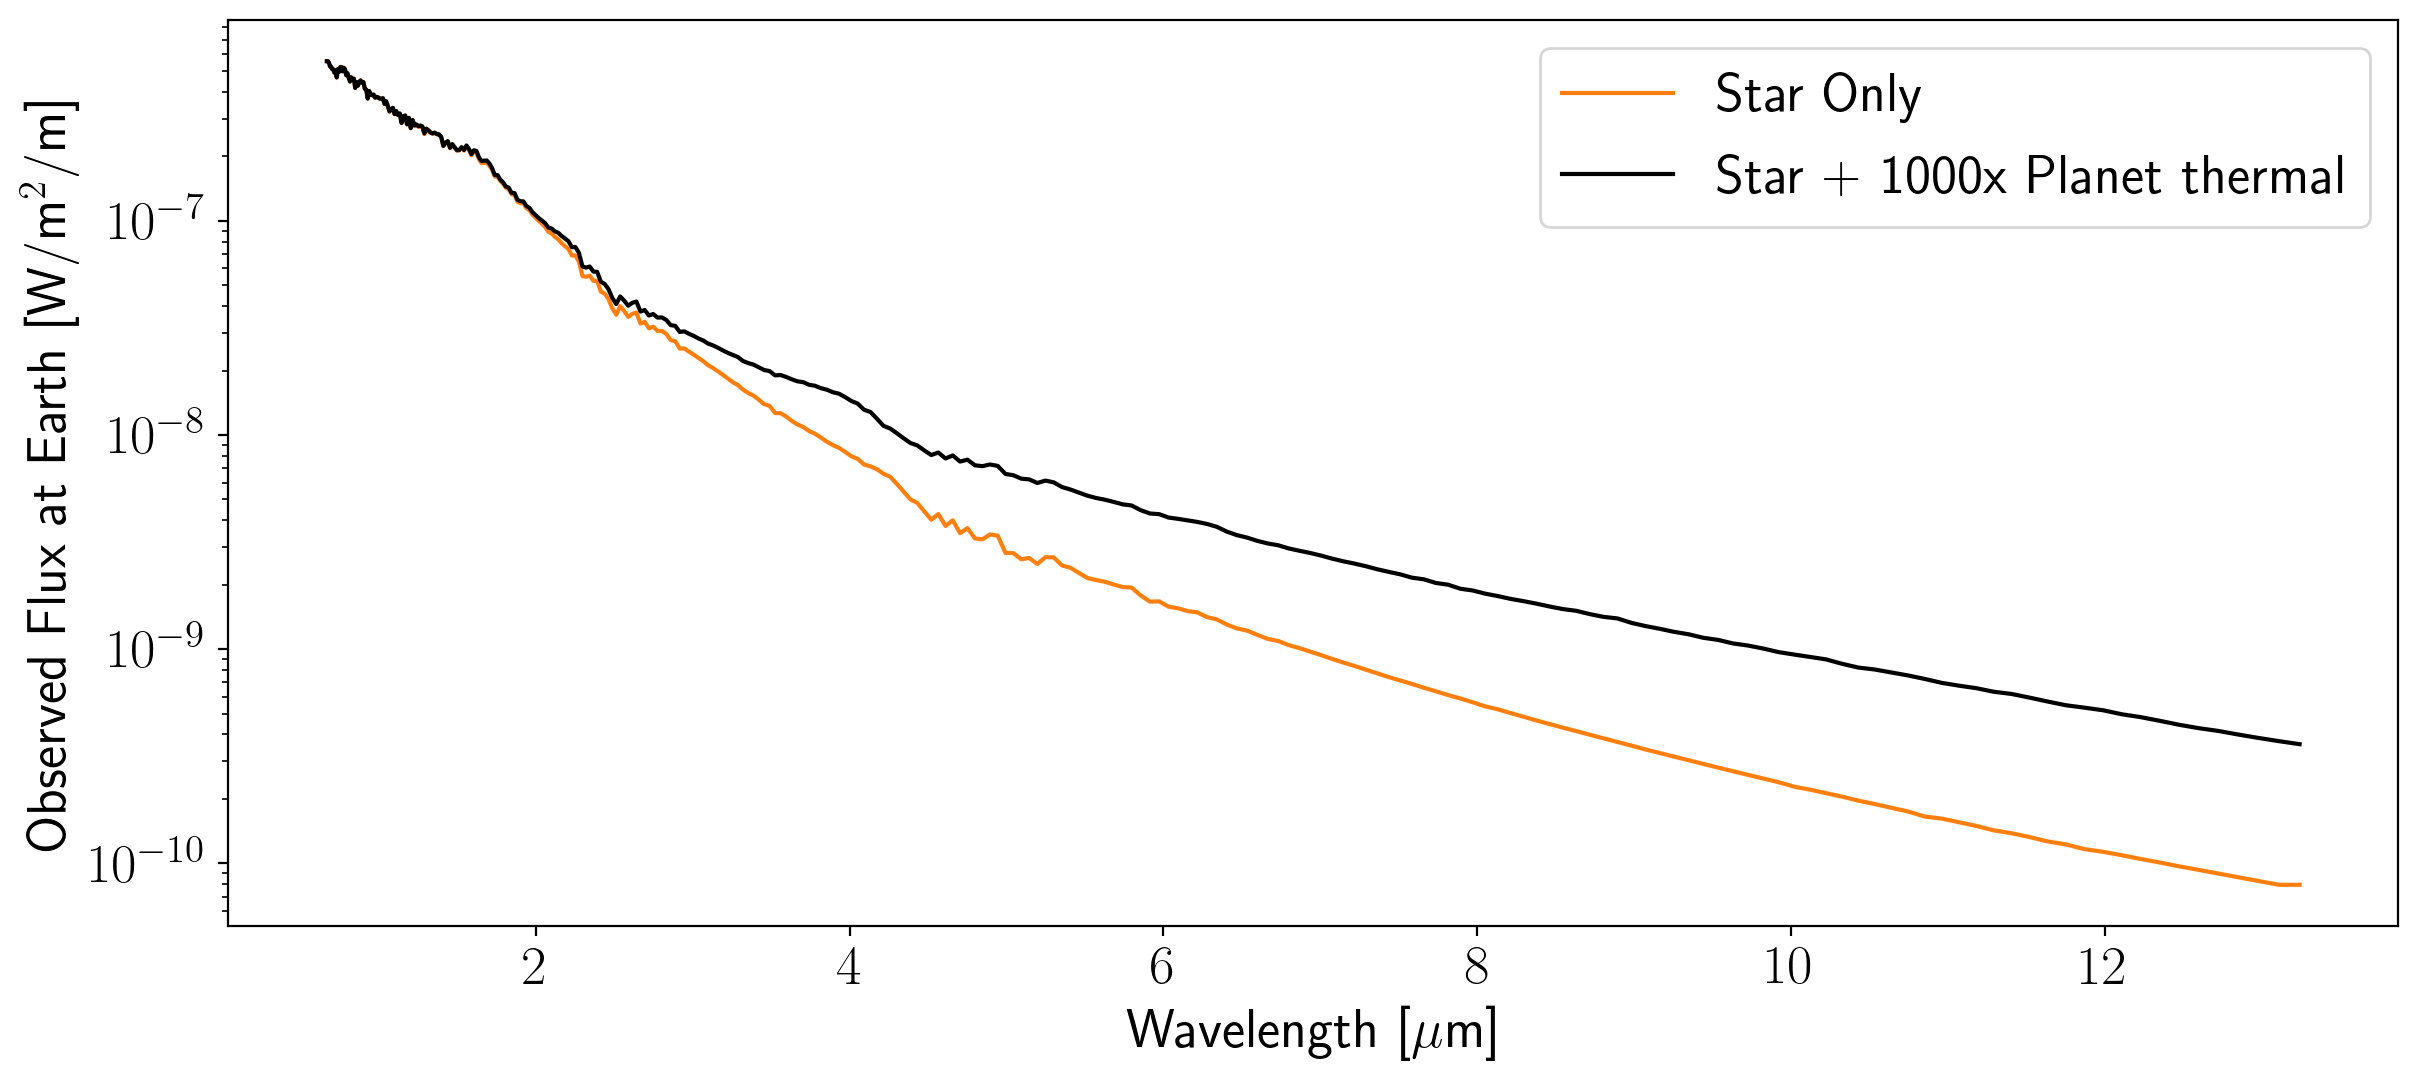

In [12]:
wl = 1e4/wno 

fig, ax = plt.subplots(figsize = (14, 6))

ax.set_xlabel("Wavelength [$\mu$m]")
ax.set_ylabel("Observed Flux at Earth [W/m$^2$/m]")

#ax.plot(wl, Ftoa, label = "Planet Thermal + Relected", color = "C2")
#ax.plot(wl, Fstar, label = "Star Only", color = "C1")
#ax.plot(wl, Fstar + Fup_therm, label = "Star + Planet thermal", color = "k")
#ax.plot(wl, Fup_therm, label = "Planet Thermal", color = "C3")
#ax.plot(wl, Fup_ref, label = "Planet Reflected", color = "C0")
#ax.plot(wl, Fup_therm + Fup_ref)

ax.plot(wl, y_star, label = "Star Only", color = "C1")
ax.plot(wl, y_star + 1000*y_planet, label = "Star + 1000x Planet thermal", color = "k")

ax.set_yscale("log")
ax.legend()

Text(0, 0.5, '$F_p/F_s$')

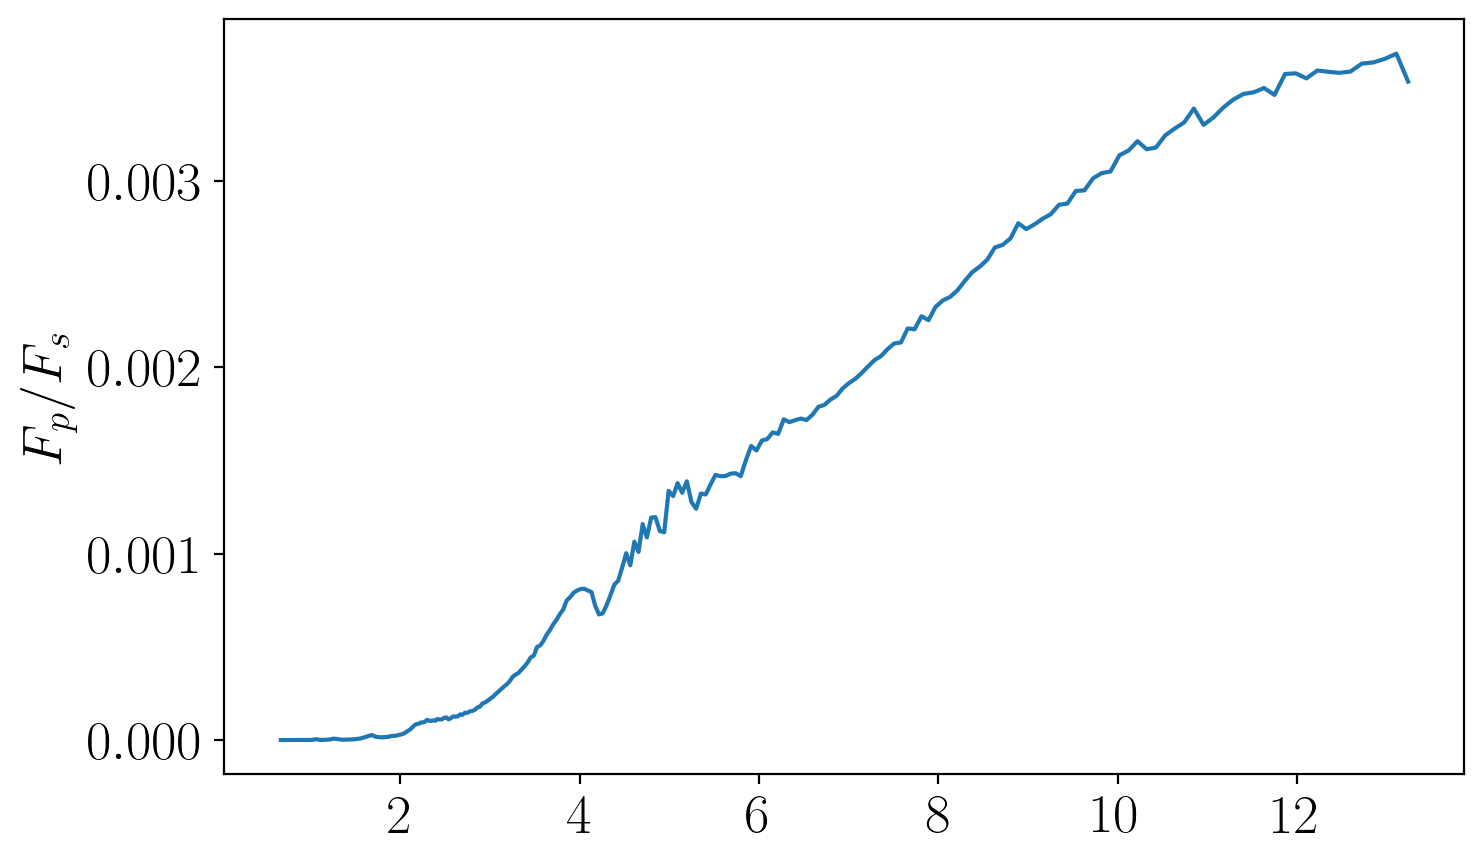

In [13]:
plt.plot(wl, (y_binned/y_star) - 1.0)
plt.ylabel("$F_p/F_s$")

# Load Kevin's errors

In [14]:
import pickle

In [15]:
# Get NIRISS Data
handle  = open('/Users/lustija1/Desktop/WASP43-ExoPIE/WASP43/niriss_soss-W43-R100.p', 'rb')
model   = pickle.load(handle)
obstime = model['RawData']['electrons_out'][0]/model['RawData']['e_rate_out'][0]/3600
print(obstime)
wave = model['FinalSpectrum']['wave']
spectrum = model['FinalSpectrum']['spectrum']
error = model['FinalSpectrum']['error_w_floor']
randspec = model['FinalSpectrum']['spectrum_w_rand']
snr = model['RawData']['electrons_out']/np.sqrt(model['RawData']['var_out'])
print(wave.min(), wave.max())

# Get NIRSpec Data
handle  = open('/Users/lustija1/Desktop/WASP43-ExoPIE/WASP43/nirspec_g395h-W43-r100.p', 'rb')
#handle  = open('niriss_soss-W43.p', 'rb')
model_g395  = pickle.load(handle)
print(model['RawData']['electrons_out'][0]/model['RawData']['e_rate_out'][0]/3600)
wave_g395 = model_g395['FinalSpectrum']['wave']
spectrum_g395 = model_g395['FinalSpectrum']['spectrum']
error_g395 = model_g395['FinalSpectrum']['error_w_floor']
randspec_g395 = model_g395['FinalSpectrum']['spectrum_w_rand']
#snr_g395 = model_g395['RawData']['electrons_out']/np.sqrt(model_g395['RawData']['var_out'])
snr_g395 = 1./error_g395
print(wave_g395.min(), wave_g395.max())


# Conbine datas
wave2   = np.concatenate((wave, wave_g395))
snr2    = np.concatenate(( snr,  snr_g395))

1.0454999999999999
0.8352500200271606 2.8087000846862793
1.0454999999999999
2.8850722678940306 5.177112799550653


In [126]:
def load_kevins_errors():
    
    # Get NIRISS Data
    handle  = open('/Users/lustija1/Desktop/WASP43-ExoPIE/WASP43/niriss_soss-W43-R100.p', 'rb')
    model   = pickle.load(handle)
    obstime = model['RawData']['electrons_out'][0]/model['RawData']['e_rate_out'][0]/3600
    print(obstime)
    wave = model['FinalSpectrum']['wave']
    spectrum = model['FinalSpectrum']['spectrum']
    error = model['FinalSpectrum']['error_w_floor']
    randspec = model['FinalSpectrum']['spectrum_w_rand']
    snr = model['RawData']['electrons_out']/np.sqrt(model['RawData']['var_out'])
    print(wave.min(), wave.max())

    # Get NIRSpec Data
    handle  = open('/Users/lustija1/Desktop/WASP43-ExoPIE/WASP43/nirspec_g395h-W43-r100.p', 'rb')
    #handle  = open('niriss_soss-W43.p', 'rb')
    model_g395  = pickle.load(handle)
    print(model['RawData']['electrons_out'][0]/model['RawData']['e_rate_out'][0]/3600)
    wave_g395 = model_g395['FinalSpectrum']['wave']
    spectrum_g395 = model_g395['FinalSpectrum']['spectrum']
    error_g395 = model_g395['FinalSpectrum']['error_w_floor']
    randspec_g395 = model_g395['FinalSpectrum']['spectrum_w_rand']
    #snr_g395 = model_g395['RawData']['electrons_out']/np.sqrt(model_g395['RawData']['var_out'])
    snr_g395 = 1./error_g395
    print(wave_g395.min(), wave_g395.max())

    # Conbine datas
    wave2   = np.concatenate((wave, wave_g395))
    snr2    = np.concatenate(( snr,  snr_g395))
    
    return wave2, snr2

Text(0, 0.5, 'S/N')

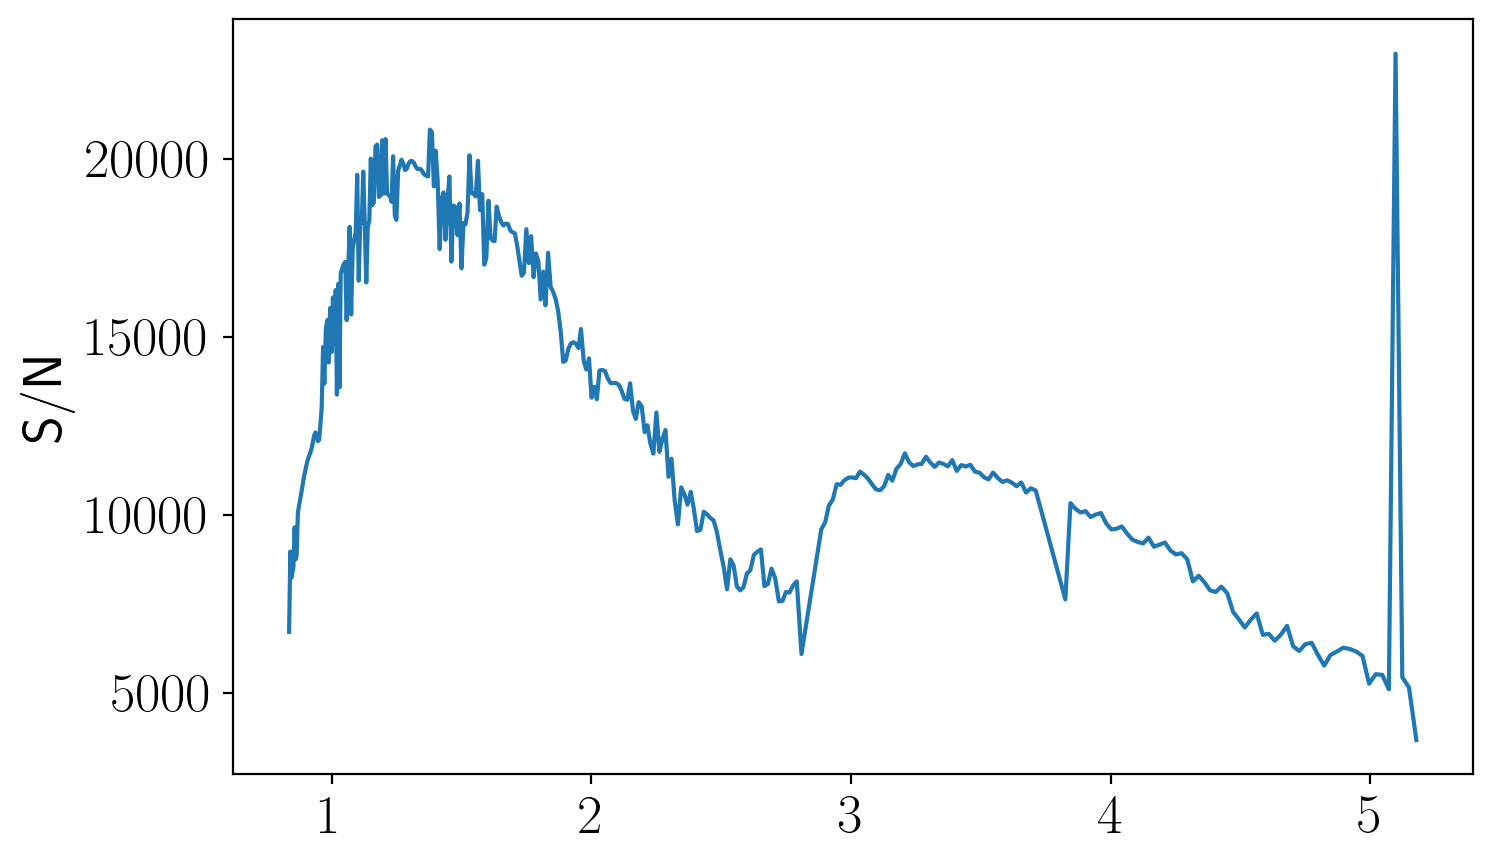

In [16]:
m = snr2 > 100
wave2 = wave2[m]
snr2 = snr2[m]

plt.plot(wave2, snr2)
plt.ylabel("S/N")

# Generate Fake Data

In [17]:
# interpolate 
y_binned2 = np.interp(wave2, wl[::-1], y_binned[::-1])
y_planet2 = np.interp(wave2, wl[::-1], y_planet[::-1])
y_star2 = np.interp(wave2, wl[::-1], y_star[::-1])

In [18]:
err = y_binned2 / snr2

# Calculate Gaussian noise
gaus = np.random.randn(len(wave2))

# Add gaussian noise to observed data
y_meas2 = y_binned2 + err * gaus

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


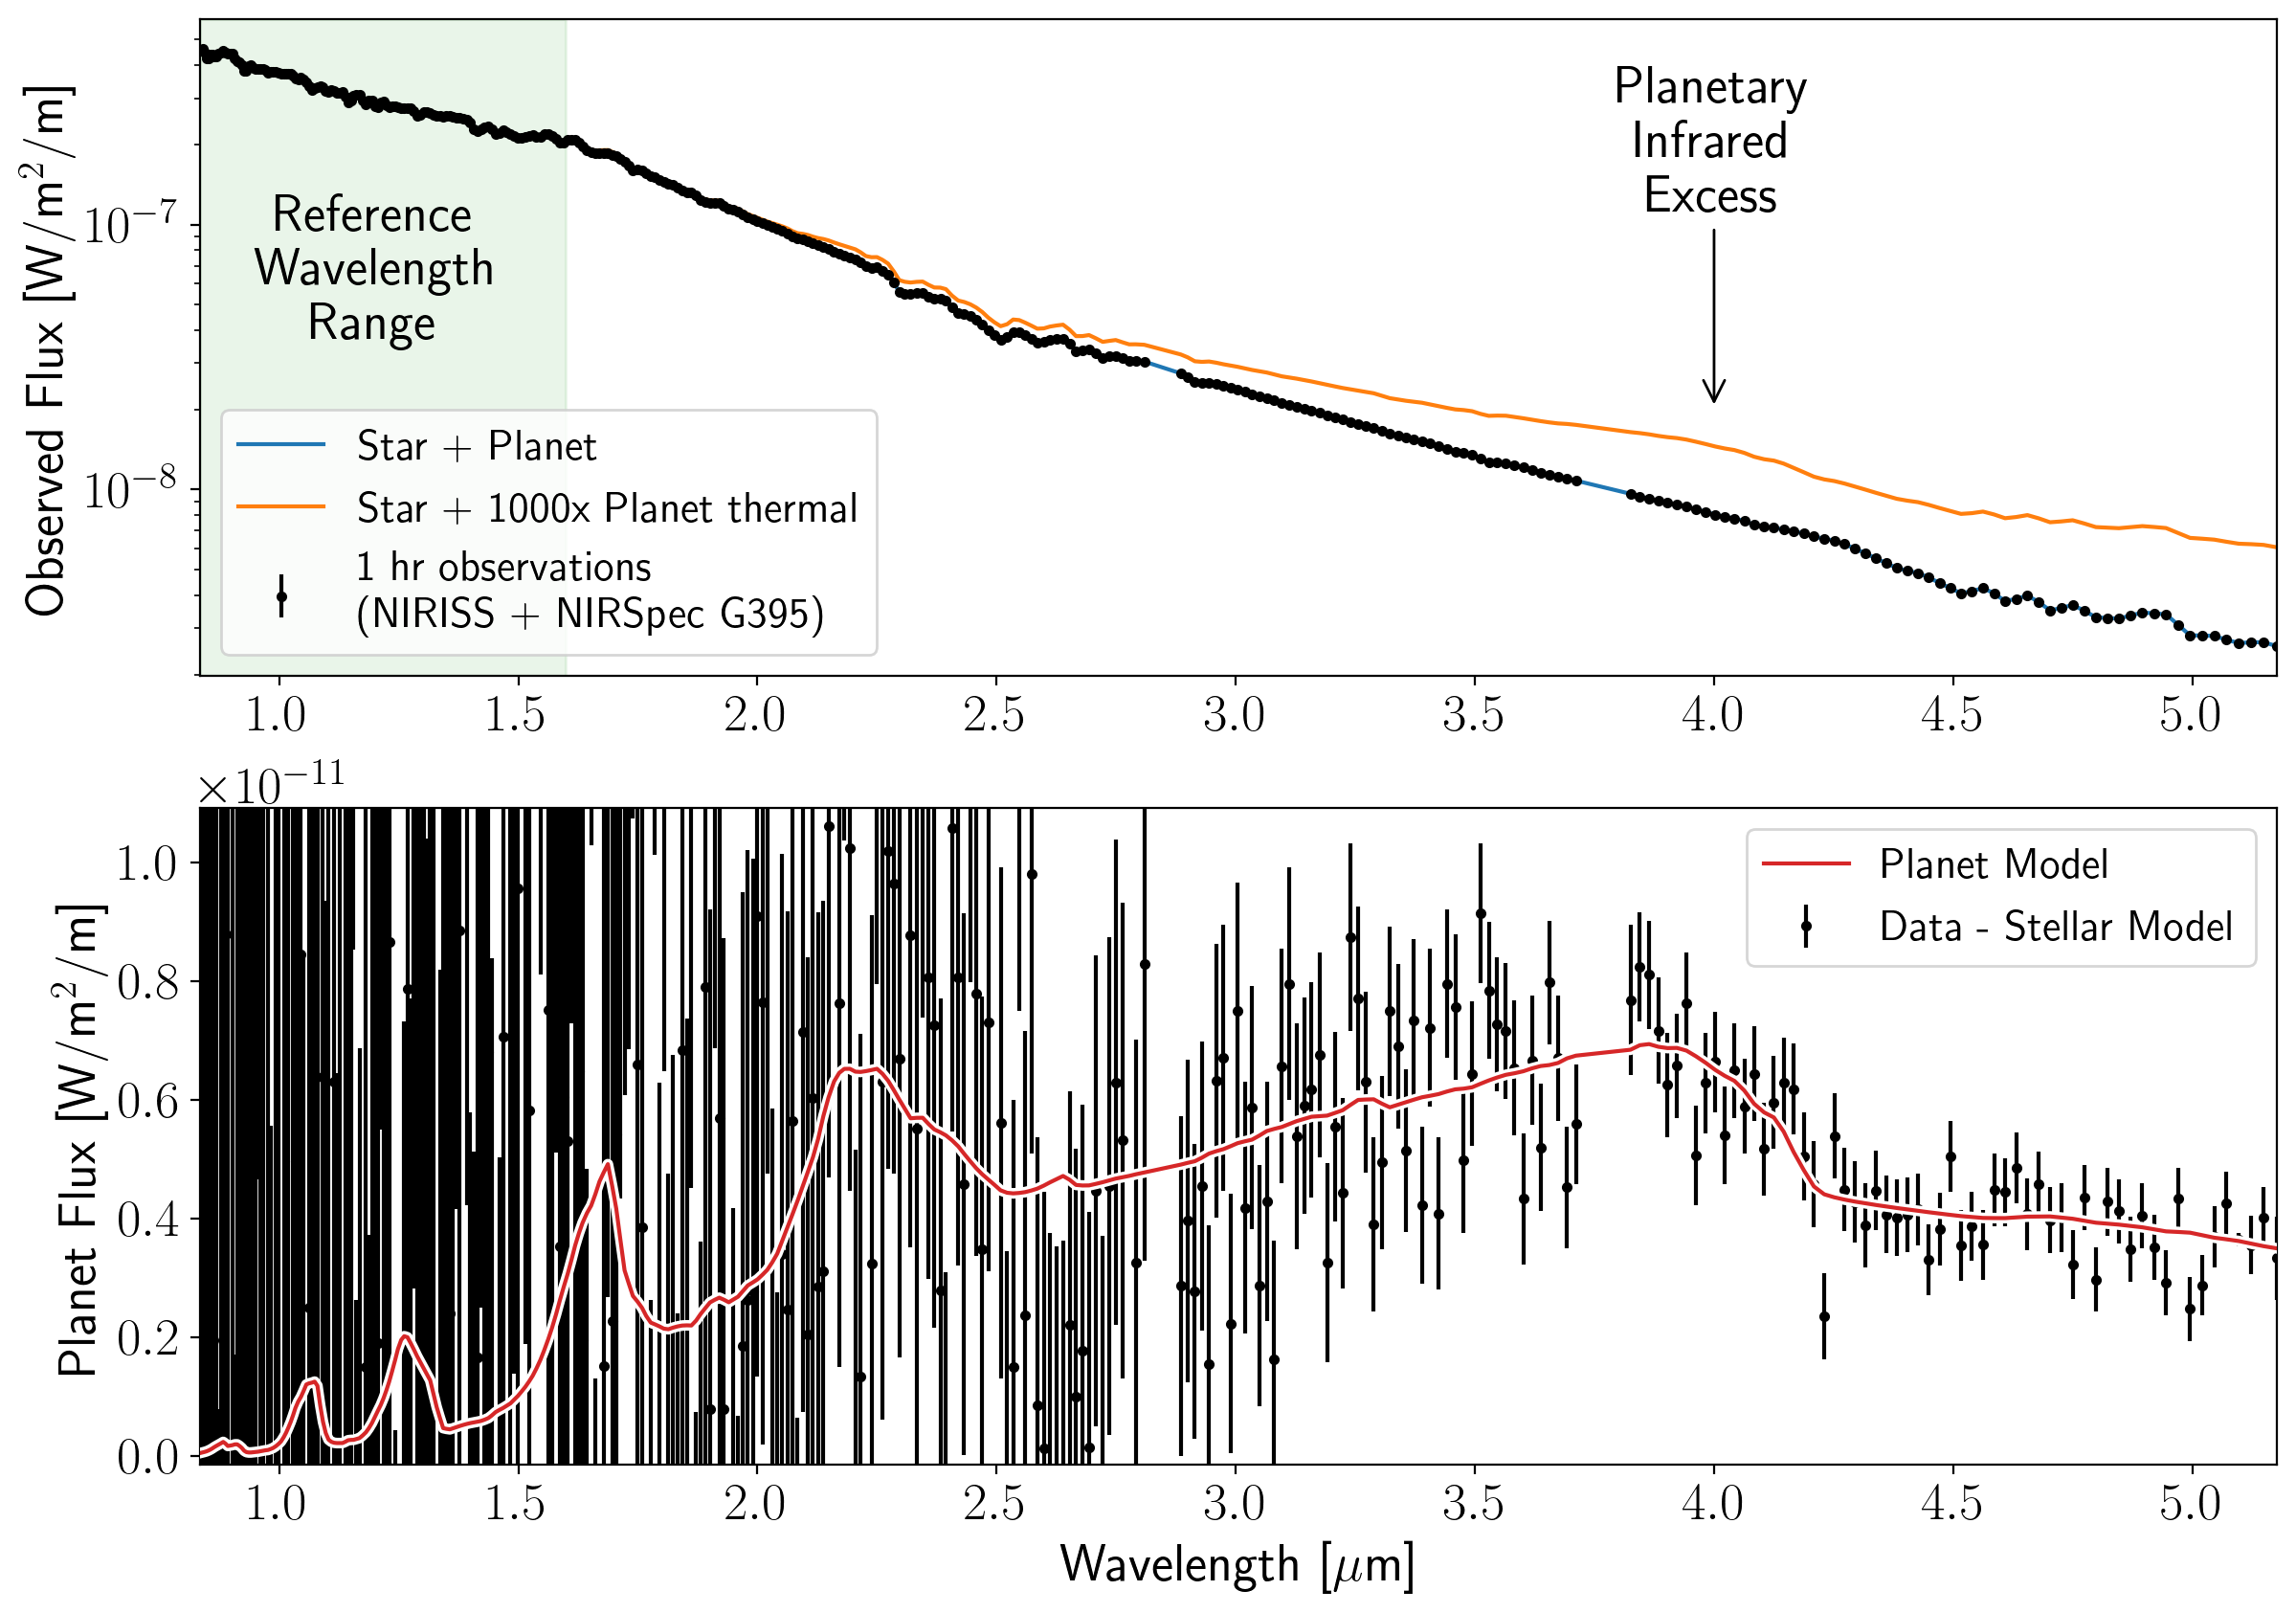

In [19]:
fig, axes = plt.subplots(2,1, figsize = (14, 10))

ax= axes[0]
ax2 = axes[1]

ax.set_xlim(wave2.min(), wave2.max())
ax2.set_xlim(wave2.min(), wave2.max())
ax2.set_xlabel("Wavelength [$\mu$m]")
ax.set_ylabel("Observed Flux [W/m$^2$/m]")

#ax.plot(wl, Ftoa, label = "Planet Thermal + Relected", color = "C2")
#ax.plot(wl, Fstar, label = "Star Only", color = "C1")
#ax.plot(wl, Fstar + Fup_therm, label = "Star + Planet thermal", color = "k")
#ax.plot(wl, Fup_therm, label = "Planet Thermal", color = "C3")
#ax.plot(wl, Fup_ref, label = "Planet Reflected", color = "C0")
#ax.plot(wl, Fup_therm + Fup_ref)

ax.plot(wave2, y_binned2, label = "Star + Planet", color = "C0")
#ax.plot(wl, y_planet, label = "Planet thermal", color = "C3")
ax.errorbar(wave2, y_meas2, yerr=err, fmt = ".k", label = "1 hr observations \n(NIRISS + NIRSpec G395)")
ax.plot(wave2, y_star2 + 1000*y_planet2, label = "Star + 1000x Planet thermal", color = "C1")
#ax.plot(wave2, y_planet2, color = "C3", label = "Planet Model")

ax.set_yscale("log")
ax.legend(fontsize = 16, loc = "lower left")

ax.axvspan(wave2.min(), 1.6, color="C2", alpha = 0.1)
ax.text(1.2, 1.3e-7, "Reference\nWavelength\nRange", ha = "center", va = "top")

ax.text(4.0, 2e-7, "Planetary\nInfrared\nExcess", ha = "center", va = "center")
ax.annotate("", xy=(4.0, 2e-8), xytext=(4.0, 1e-7), arrowprops=dict(arrowstyle="->"))

ax2.set_ylabel("Planet Flux [W/m$^2$/m]")
ax2.plot(wave2, y_planet2, color = "w", lw = 4.0, zorder = 100)
ax2.plot(wave2, y_planet2, color = "C3", label = "Planet Model", zorder = 100)
ylim = ax2.get_ylim()
ax2.errorbar(wave2, y_meas2 - y_star2, yerr = err, fmt=".k", label = "Data - Stellar Model")
ax2.set_ylim(0.5*ylim[0], 1.5*ylim[1])
ax2.legend(fontsize = 16)
#ax2.set_yscale("log")

#fig.savefig("/Users/lustija1/Documents/exoPIE_IRAD/W43b_PIE_Fp.png", bbox_inches = "tight")

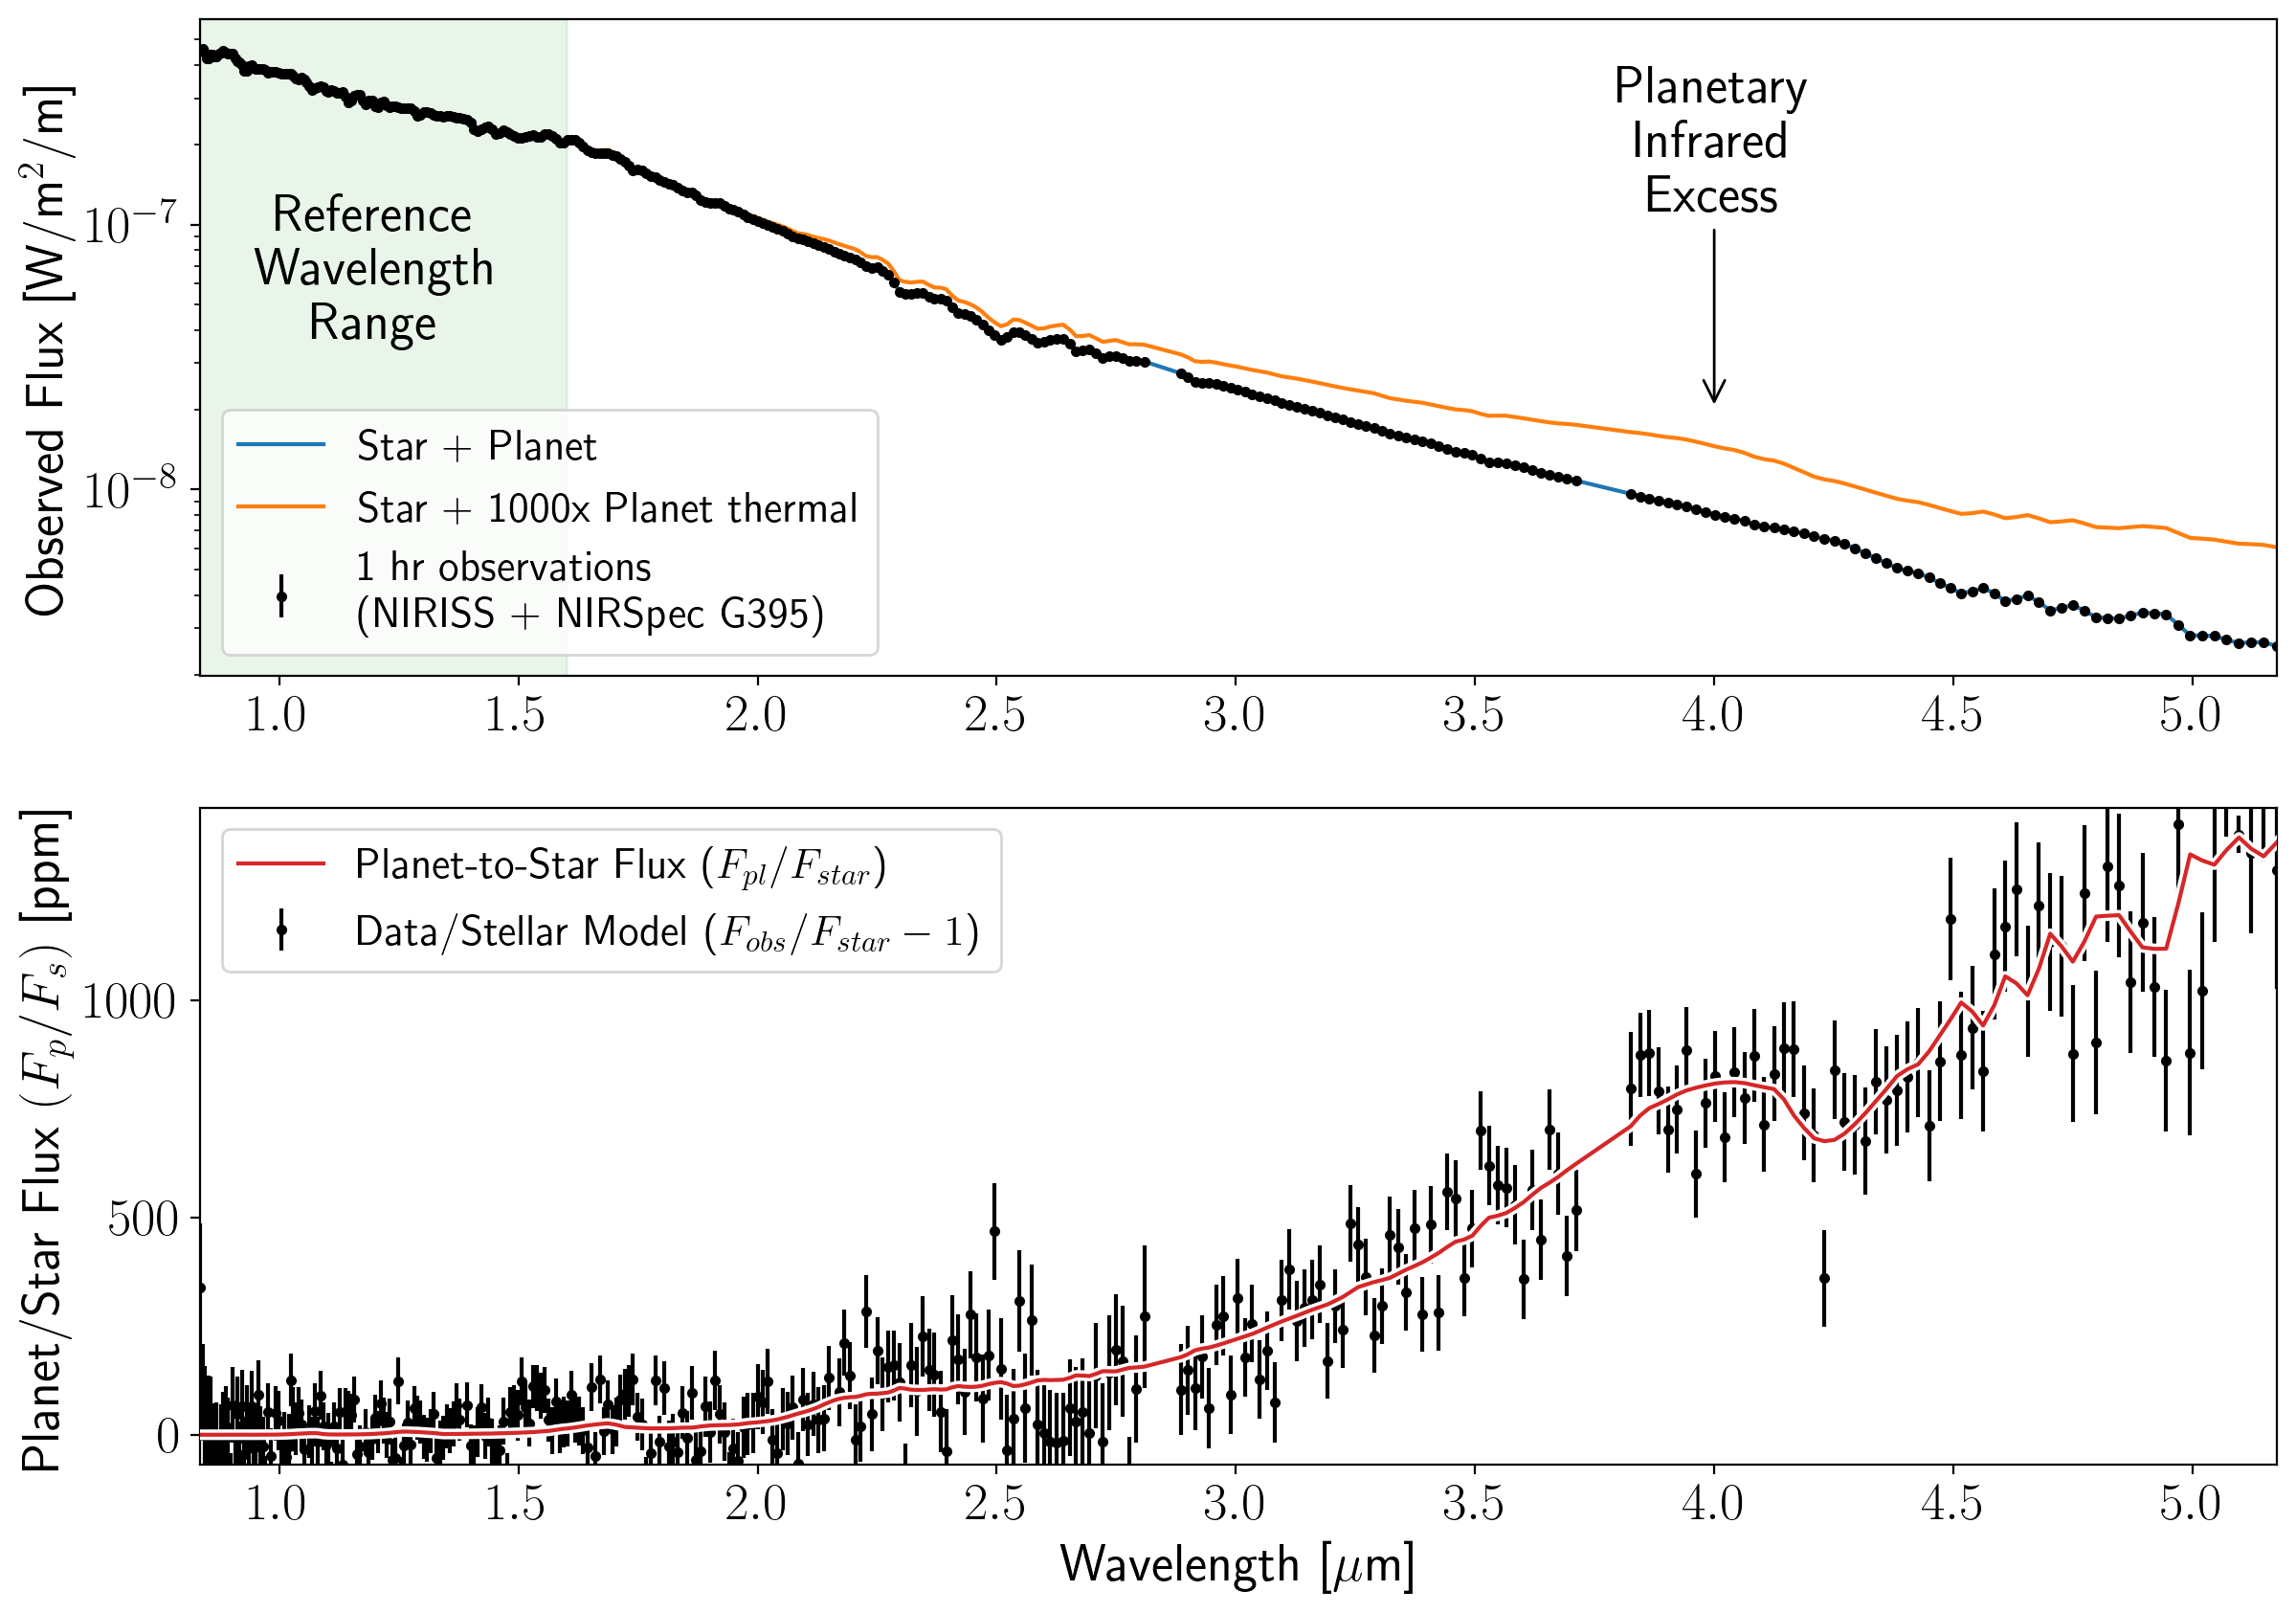

In [20]:
fig, axes = plt.subplots(2,1, figsize = (14, 10))

ax= axes[0]
ax2 = axes[1]

ax.set_xlim(wave2.min(), wave2.max())
ax2.set_xlim(wave2.min(), wave2.max())
ax2.set_xlabel("Wavelength [$\mu$m]")
ax.set_ylabel("Observed Flux [W/m$^2$/m]")

#ax.plot(wl, Ftoa, label = "Planet Thermal + Relected", color = "C2")
#ax.plot(wl, Fstar, label = "Star Only", color = "C1")
#ax.plot(wl, Fstar + Fup_therm, label = "Star + Planet thermal", color = "k")
#ax.plot(wl, Fup_therm, label = "Planet Thermal", color = "C3")
#ax.plot(wl, Fup_ref, label = "Planet Reflected", color = "C0")
#ax.plot(wl, Fup_therm + Fup_ref)

ax.plot(wave2, y_binned2, label = "Star + Planet", color = "C0")
#ax.plot(wl, y_planet, label = "Planet thermal", color = "C3")
ax.errorbar(wave2, y_meas2, yerr=err, fmt = ".k", label = "1 hr observations \n(NIRISS + NIRSpec G395)")
ax.plot(wave2, y_star2 + 1000*y_planet2, label = "Star + 1000x Planet thermal", color = "C1")
#ax.plot(wave2, y_planet2, color = "C3", label = "Planet Model")

ax.set_yscale("log")
ax.legend(fontsize = 16, loc = "lower left")

ax.axvspan(wave2.min(), 1.6, color="C2", alpha = 0.1)
ax.text(1.2, 1.3e-7, "Reference\nWavelength\nRange", ha = "center", va = "top")

ax.text(4.0, 2e-7, "Planetary\nInfrared\nExcess", ha = "center", va = "center")
ax.annotate("", xy=(4.0, 2e-8), xytext=(4.0, 1e-7), arrowprops=dict(arrowstyle="->"))

ax2.set_ylabel("Planet/Star Flux $(F_p/F_s)$ [ppm]")
ax2.plot(wave2, 1e6*(y_binned2/y_star2-1.0), color = "w", lw = 4.0, zorder = 100)
ax2.plot(wave2, 1e6*(y_binned2/y_star2-1.0), color = "C3", label = "Planet-to-Star Flux ($F_{pl}/F_{star}$)", zorder = 100)
ylim = ax2.get_ylim()
ax2.errorbar(wave2, 1e6*(y_meas2/y_star2-1.0), yerr = 1e6*(err/y_star2), fmt=".k", label = "Data/Stellar Model ($F_{obs} / F_{star} - 1$)")
ax2.set_ylim(ylim[0], ylim[1])
ax2.legend(fontsize = 16)
#ax2.set_yscale("log")

#fig.savefig("/Users/lustija1/Documents/exoPIE_IRAD/W43b_PIE_FpFs.png", bbox_inches = "tight")

# Run initial Retrieval 

In [80]:
x, y, yerr = wave2, y_meas2, err

In [83]:
# Given a datafile, bin to CHIMERA's R=100 grid (This feels DUMB!)
wnomin = np.floor(np.min(1e4 / x))
wnomax = np.ceil(np.max(1e4 / x))

observatory='JWST'
directory = os.path.join(os.getcwd(), '..','ABSCOEFF_CK')
xsecs=chimera.xsects(wnomin, wnomax, observatory, directory,stellar_file=None)
xsecs = list(xsecs)  # This appears necessary to set the stellar flux *within* fx

Cross-sections Loaded


In [84]:
# Chimera Grids
wno = xsecs[2]
wl = 1e4 / wno

In [85]:
# Define bin widths
dwl = wl[:-1] - wl[1:]
mwl = 0.5*(wl[:-1] + wl[1:])
dwl = sp.interpolate.interp1d(mwl, dwl, fill_value="extrapolate")(wl)

In [87]:
# Rebin data to CHIMERA grid
y_meas_binned, y_err_binned = cg.downbin_spec_err(y, yerr, x, wl[::-1], dlam=dwl[::-1])
y_meas = y_meas_binned[::-1]
y_err = y_err_binned[::-1]

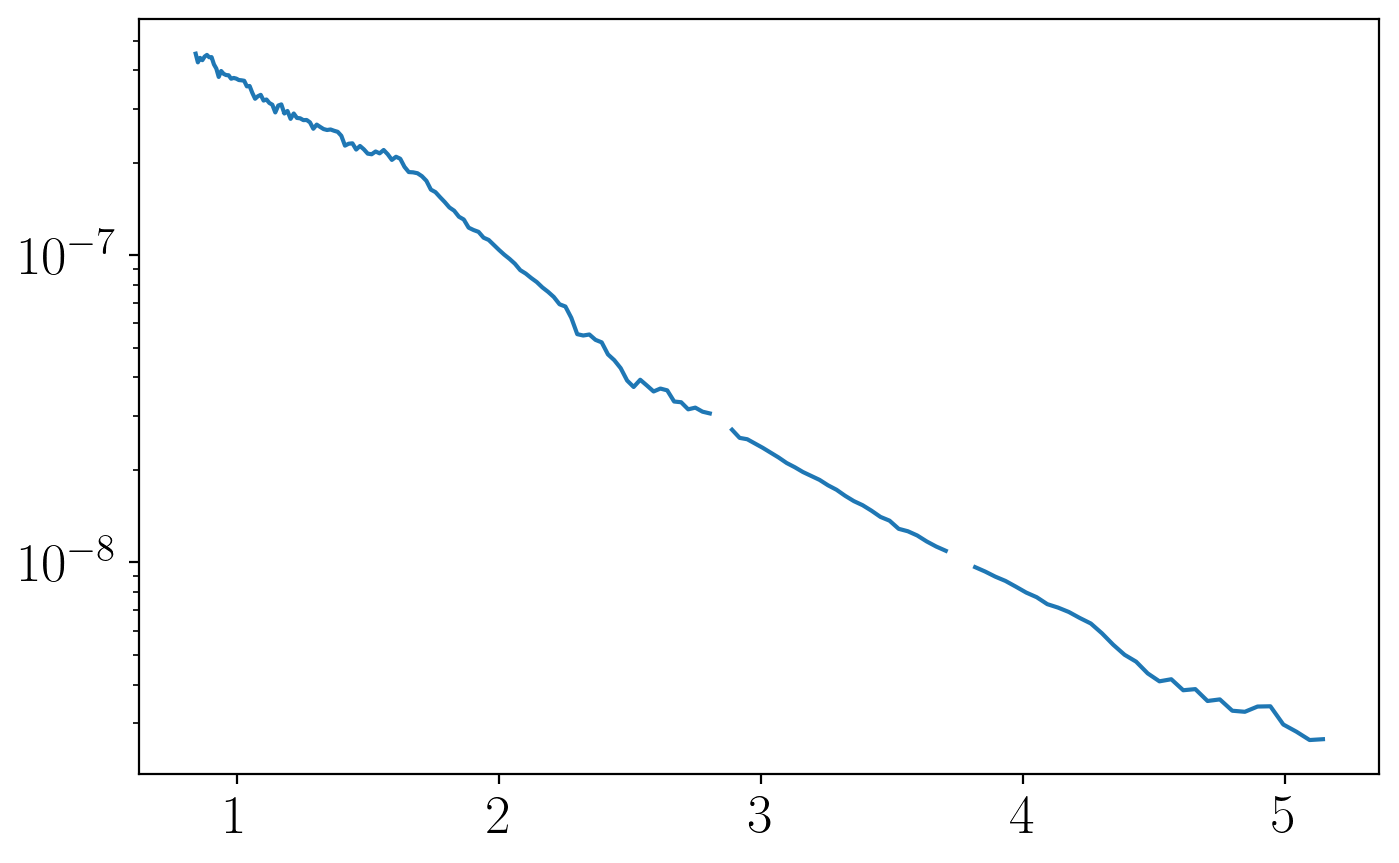

In [89]:
plt.errorbar(wl, y_meas, yerr=y_err)
plt.yscale("log")

In [90]:
import corner, emcee

In [124]:
def run_pie_model(theta):

    #setup "input" parameters. We are defining our 1D atmosphere with these
    #the parameters
    #planet/star system params--xRp is the "Rp" free parameter, M right now is fixed, but could be free param
    Rp=0.93   #Planet radius in Jupiter Radii--this will be forced to be 10 bar radius--arbitrary (scaling to this is free par)
    Rstar=0.6 # #Stellar Radius in Solar Radii
    M = 1.776   #Mass in Jupiter Masses
    D=0.014   #semimajor axis in AU--for reflected light component

    #TP profile params (3--Guillot 2010, Parmentier & Guillot 2013--see Line et al. 2013a for implementation)
    Tirr=1000     #Irradiation temperature as defined in Guillot 2010
    logKir=-1.5  #TP profile IR opacity (log there-of) controlls the "vertical" location of the gradient
    logg1=-0.7     #single channel Vis/IR (log) opacity. Controls the delta T between deep T and TOA T
    Tint=200 #interior temperature...this would be the "effective temperature" if object were not irradiated

    #Composition parameters---assumes "chemically consistent model" described in Kreidberg et al. 2015
    logMet=0.0  #.   #Metallicity relative to solar log--solar is 0, 10x=1, 0.1x = -1: valid range is -1.5 - 3.0
    logCtoO=-0.26   #log C-to-O ratio: log solar is -0.26: valid range is -1.0 - 0.3 
    logPQCarbon=-5.5  #CH4, CO, H2O Qunech pressure--forces CH4, CO, and H2O to constant value at quench pressure value: valid range -6.0 - 1.5
    logPQNitrogen=-5.5  #N2, NH3 Quench pressure--forces N2 and NH3 to ""  

    #Ackerman & Marley 2001 Cloud parameters--physically motivated with Mie particles
    logKzz=7 #log Kzz (cm2/s)--valid range: 2 - 11 -- higher values make larger particles
    fsed=2.0 #sediminetation efficiency--valid range: 0.5 - 5--lower values make "puffier" more extended cloud 
    logPbase=-1.0  #cloud base pressure--valid range: -6.0 - 1.5
    logCldVMR=-5.5 #cloud condensate base mixing ratio (e.g, see Fortney 2005)--valid range: -15 - -2.0

    #simple 'grey+rayleigh' parameters just in case you don't want to use a physically motivated cloud
    #(most are just made up anyway since we don't really understand all of the micro-physics.....)
    logKcld = -40  #uniform in altitude and in wavelength "grey" opacity (it's a cross-section)--valid range: -50 - -10 
    logRayAmp = -30  #power-law haze amplitude (log) as defined in des Etangs 2008 "0" would be like H2/He scat--valid range: -30 - 3 
    RaySlope = 0  #power law index 4 for Rayleigh, 0 for "gray".  Valid range: 0 - 6
    
    # Stellar parameters
    Teff = 4400.     # Stellar effective temperature [K]
    logMH = -0.05    # Stellar metallicity 
    logg = 4.646     # Stellar log gravity 
    d = 80.0         # Stellar distance
    
    #unpacking parameters to retrieve (these override the fixed values above)
    Teff, Tirr, logKir, logg1 = theta
    
    #stuffing all variables into state vector array
    x=np.array([Tirr, logKir,logg1, Tint, logMet, logCtoO, logPQCarbon,logPQNitrogen, Rp, Rstar, M, D, logKzz, fsed,logPbase,logCldVMR, logKcld, logRayAmp, RaySlope, Teff, logMH, logg, d])

    #gas scaling factors to mess with turning on various species
    #set to "0" to turn off a gas. Otherwise keep set at 1
    #thermochemical gas profile scaling factors
    # 0   1    2    3   4    5    6     7    8    9   10    11   12   13    14   15   16   17   18  19 20   21
    #H2O  CH4  CO  CO2 NH3  N2   HCN   H2S  PH3  C2H2 C2H6  Na    K   TiO   VO   FeH  H    H2   He   e- h-  mmw
    gas_scale=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1., 1., 1.]) #can be made free params if desired (won't affect mmw)#can be made free params if desired (won't affect mmw)

    # Run chimera forward model
    foo = chimera.fx_emis_pie(x, wlgrid, gas_scale, xsecs)
    y_binned,y_mod,wno,atm,Ftoa,Fstar,Fstar_TOA,Fup_therm,Fup_ref= foo
    
    # Convert fluxes to Earth distances
    Fstar_earth = Fstar*( Rstar * u.Rsun.in_units(u.m) / (d * u.pc.in_units(u.m)))**2
    #Fplan_earth = Ftoa * ( Rp * u.Rjup.in_units(u.m) / (d * u.pc.in_units(u.m)))**2
    Fplan_therm_earth = Fup_therm * ( Rp * u.Rjup.in_units(u.m) / (d * u.pc.in_units(u.m)))**2
    
    # Sum flux components
    Fobs = Fstar_earth + Fplan_therm_earth

    return Fobs, Fstar_earth, Fplan_therm_earth

def run_pie_model_general(theta):
    
    # Create dictionary
    theta_dict = dict(zip(theta_names, theta))
    
    # Unpack parameters to retrieve if they are in state vector 
    # otherwise use the default fixed values

    #setup "input" parameters. We are defining our 1D atmosphere with these
    #the parameters
    #planet/star system params--xRp is the "Rp" free parameter, M right now is fixed, but could be free param
    Rp = theta_dict.get("Rp", 0.93)      # Planet radius in Jupiter Radii--this will be forced to be 10 bar radius--arbitrary (scaling to this is free par)
    Rstar = theta_dict.get("Rstar", 0.6) # Stellar Radius in Solar Radii
    M = theta_dict.get("M", 1.776)       # Mass in Jupiter Masses
    D=theta_dict.get("D", 0.014)        # Semimajor axis in AU--for reflected light component

    #TP profile params (3--Guillot 2010, Parmentier & Guillot 2013--see Line et al. 2013a for implementation)
    Tirr=theta_dict.get("Tirr", 1000)       # Irradiation temperature as defined in Guillot 2010
    logKir=theta_dict.get("logKir", -1.5)   # TP profile IR opacity (log there-of) controlls the "vertical" location of the gradient
    logg1=theta_dict.get("logg1", -0.7)     # single channel Vis/IR (log) opacity. Controls the delta T between deep T and TOA T
    Tint=theta_dict.get("Tint", 200)        # interior temperature...this would be the "effective temperature" if object were not irradiated

    #Composition parameters---assumes "chemically consistent model" described in Kreidberg et al. 2015
    logMet=theta_dict.get("logMet", 2.0)                # Metallicity relative to solar log--solar is 0, 10x=1, 0.1x = -1: valid range is -1.5 - 3.0
    logCtoO=theta_dict.get("logCtoO", -1.0)            # log C-to-O ratio: log solar is -0.26: valid range is -1.0 - 0.3 
    logPQCarbon=theta_dict.get("logPQCarbon", -5.5)     # CH4, CO, H2O Qunech pressure--forces CH4, CO, and H2O to constant value at quench pressure value: valid range -6.0 - 1.5
    logPQNitrogen=theta_dict.get("logPQNitrogen", -5.5) # N2, NH3 Quench pressure--forces N2 and NH3 to ""  

    #Ackerman & Marley 2001 Cloud parameters--physically motivated with Mie particles
    logKzz=theta_dict.get("logKzz", 7)          # log Kzz (cm2/s)--valid range: 2 - 11 -- higher values make larger particles
    fsed=theta_dict.get("fsed", 2.0)            # sediminetation efficiency--valid range: 0.5 - 5--lower values make "puffier" more extended cloud 
    logPbase=theta_dict.get("logPbase", -1.0)   # cloud base pressure--valid range: -6.0 - 1.5
    logCldVMR=theta_dict.get("logCldVMR", -5.5) # cloud condensate base mixing ratio (e.g, see Fortney 2005)--valid range: -15 - -2.0

    #simple 'grey+rayleigh' parameters just in case you don't want to use a physically motivated cloud
    #(most are just made up anyway since we don't really understand all of the micro-physics.....)
    logKcld = theta_dict.get("logKcld", -40)      # uniform in altitude and in wavelength "grey" opacity (it's a cross-section)--valid range: -50 - -10 
    logRayAmp = theta_dict.get("logRayAmp", -30)  # power-law haze amplitude (log) as defined in des Etangs 2008 "0" would be like H2/He scat--valid range: -30 - 3 
    RaySlope = theta_dict.get("RaySlope", 0)      # power law index 4 for Rayleigh, 0 for "gray".  Valid range: 0 - 6
    
    # Stellar parameters
    Teff = theta_dict.get("Teff", 4400.)     # Stellar effective temperature [K]
    logMH = theta_dict.get("logMH", -0.05)   # Stellar metallicity 
    logg = theta_dict.get("logg", 4.646)     # Stellar log gravity 
    d = theta_dict.get("d", 80.0)            # Stellar distance
    
    #unpacking parameters to retrieve (these override the fixed values above)
    #Teff, Tirr, logKir, logg1 = theta
    
    #stuffing all variables into state vector array
    x=np.array([Tirr, logKir,logg1, Tint, logMet, logCtoO, logPQCarbon,logPQNitrogen, Rp, Rstar, M, D, logKzz, fsed,logPbase,logCldVMR, logKcld, logRayAmp, RaySlope, Teff, logMH, logg, d])

    #gas scaling factors to mess with turning on various species
    #set to "0" to turn off a gas. Otherwise keep set at 1
    #thermochemical gas profile scaling factors
    # 0   1    2    3   4    5    6     7    8    9   10    11   12   13    14   15   16   17   18  19 20   21
    #H2O  CH4  CO  CO2 NH3  N2   HCN   H2S  PH3  C2H2 C2H6  Na    K   TiO   VO   FeH  H    H2   He   e- h-  mmw
    gas_scale=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1., 1., 1.]) #can be made free params if desired (won't affect mmw)#can be made free params if desired (won't affect mmw)

    # Run chimera forward model
    foo = chimera.fx_emis_pie(x, wlgrid, gas_scale, xsecs)
    y_binned,y_mod,wno,atm,Ftoa,Fstar,Fstar_TOA,Fup_therm,Fup_ref= foo
    
    # Convert fluxes to Earth distances
    Fstar_earth = Fstar*( Rstar * u.Rsun.in_units(u.m) / (d * u.pc.in_units(u.m)))**2
    #Fplan_earth = Ftoa * ( Rp * u.Rjup.in_units(u.m) / (d * u.pc.in_units(u.m)))**2
    Fplan_therm_earth = Fup_therm * ( Rp * u.Rjup.in_units(u.m) / (d * u.pc.in_units(u.m)))**2
    
    # Sum flux components
    Fobs = Fstar_earth + Fplan_therm_earth

    return Fobs, Fstar_earth, Fplan_therm_earth

#defining log-likelihood function
# log-likelihood
def loglike(theta):

    y_binned, y_star, y_planet = run_pie_model_general(theta)

    loglikelihood=-0.5*np.nansum((y_meas-y_binned)**2/y_err**2)  #your typical "quadratic" or "chi-square"

    return loglikelihood

def neg_loglike(theta):
    return -loglike(theta)

In [128]:
theta_names = {}

foo = run_pie_model_general([])

In [120]:
priors = [
    smarter.priors.GaussianPrior(4400, 200, theta_name = "Teff"),
    #smarter.priors.GaussianPrior(-0.05, 0.17, theta_name = "logMH"), 
    #smarter.priors.GaussianPrior(4.646, 0.052, theta_name = "logg"),
    #smarter.priors.GaussianPrior(0.6, 0.038, theta_name = "Rstar"),
    #smarter.priors.GaussianPrior(80, 22.97, theta_name = "d"),
    smarter.priors.UniformPrior(300., 3000., theta_name = "Tirr"), 
    smarter.priors.UniformPrior(-3.0, 0.0, theta_name = "logKir"), 
    smarter.priors.UniformPrior(-3.0, 1.0, theta_name = "logg1"), 
    #smarter.priors.UniformPrior(0.0, 500.0, theta_name = "Tint"), 
    #smarter.priors.UniformPrior(-3.0, 3.0, theta_name = "logMet"), 
    #smarter.priors.UniformPrior(-2.0, 2.0, theta_name = "logCtoO"), 
    #smarter.priors.UniformPrior(-7.5, 1.5, theta_name = "logPQCarbon"), 
    #smarter.priors.UniformPrior(-7.5, 1.5, theta_name = "logPQNitrogen"), 
    #smarter.priors.GaussianPrior(0.93, 0.038, theta_name = "Rp"),
]

theta0 = [4400., 1000.0, -1.5, -0.7]

theta_names = [prior.theta_name for prior in priors]

smarter.priors.get_lnprior(theta0, priors)

-16.60316960153313

In [121]:
def logprob(theta):
    
    lp = smarter.priors.get_lnprior(theta, priors)
    
    if np.isfinite(lp):
        return loglike(theta)
    
    return -np.inf

In [123]:
# Test end-to-end model
%timeit logprob(theta0)

5.26 s ± 195 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [107]:
ndim, nwalkers = len(priors), 10

# Get n random samples from each of your parameter prior
p0 = np.vstack([prior.random_sample(nwalkers) for prior in priors]).T

sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob, threads=1)
result = sampler.run_mcmc(p0, 10, progress=True)

100%|██████████| 10/10 [07:23<00:00, 44.36s/it]


In [ ]:
# Restart existing MCMC to continue where it left off
result = sampler.run_mcmc(result.coords, 100, progress=True)

 16%|█▌        | 16/100 [24:38<2:15:08, 96.53s/it]

/Users/lustija1/opt/anaconda3/lib/python3.8/site-packages/emcee/autocorr.py:36: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]
/Users/lustija1/opt/anaconda3/lib/python3.8/site-packages/emcee/autocorr.py:41: RuntimeWarning: invalid value encountered in less
  m = np.arange(len(taus)) < c * taus
/Users/lustija1/opt/anaconda3/lib/python3.8/site-packages/emcee/autocorr.py:99: RuntimeWarning: invalid value encountered in greater
  flag = tol * tau_est > n_t


Mean acceptance fraction: 34.00%
Mean autocorrelation time: nan steps


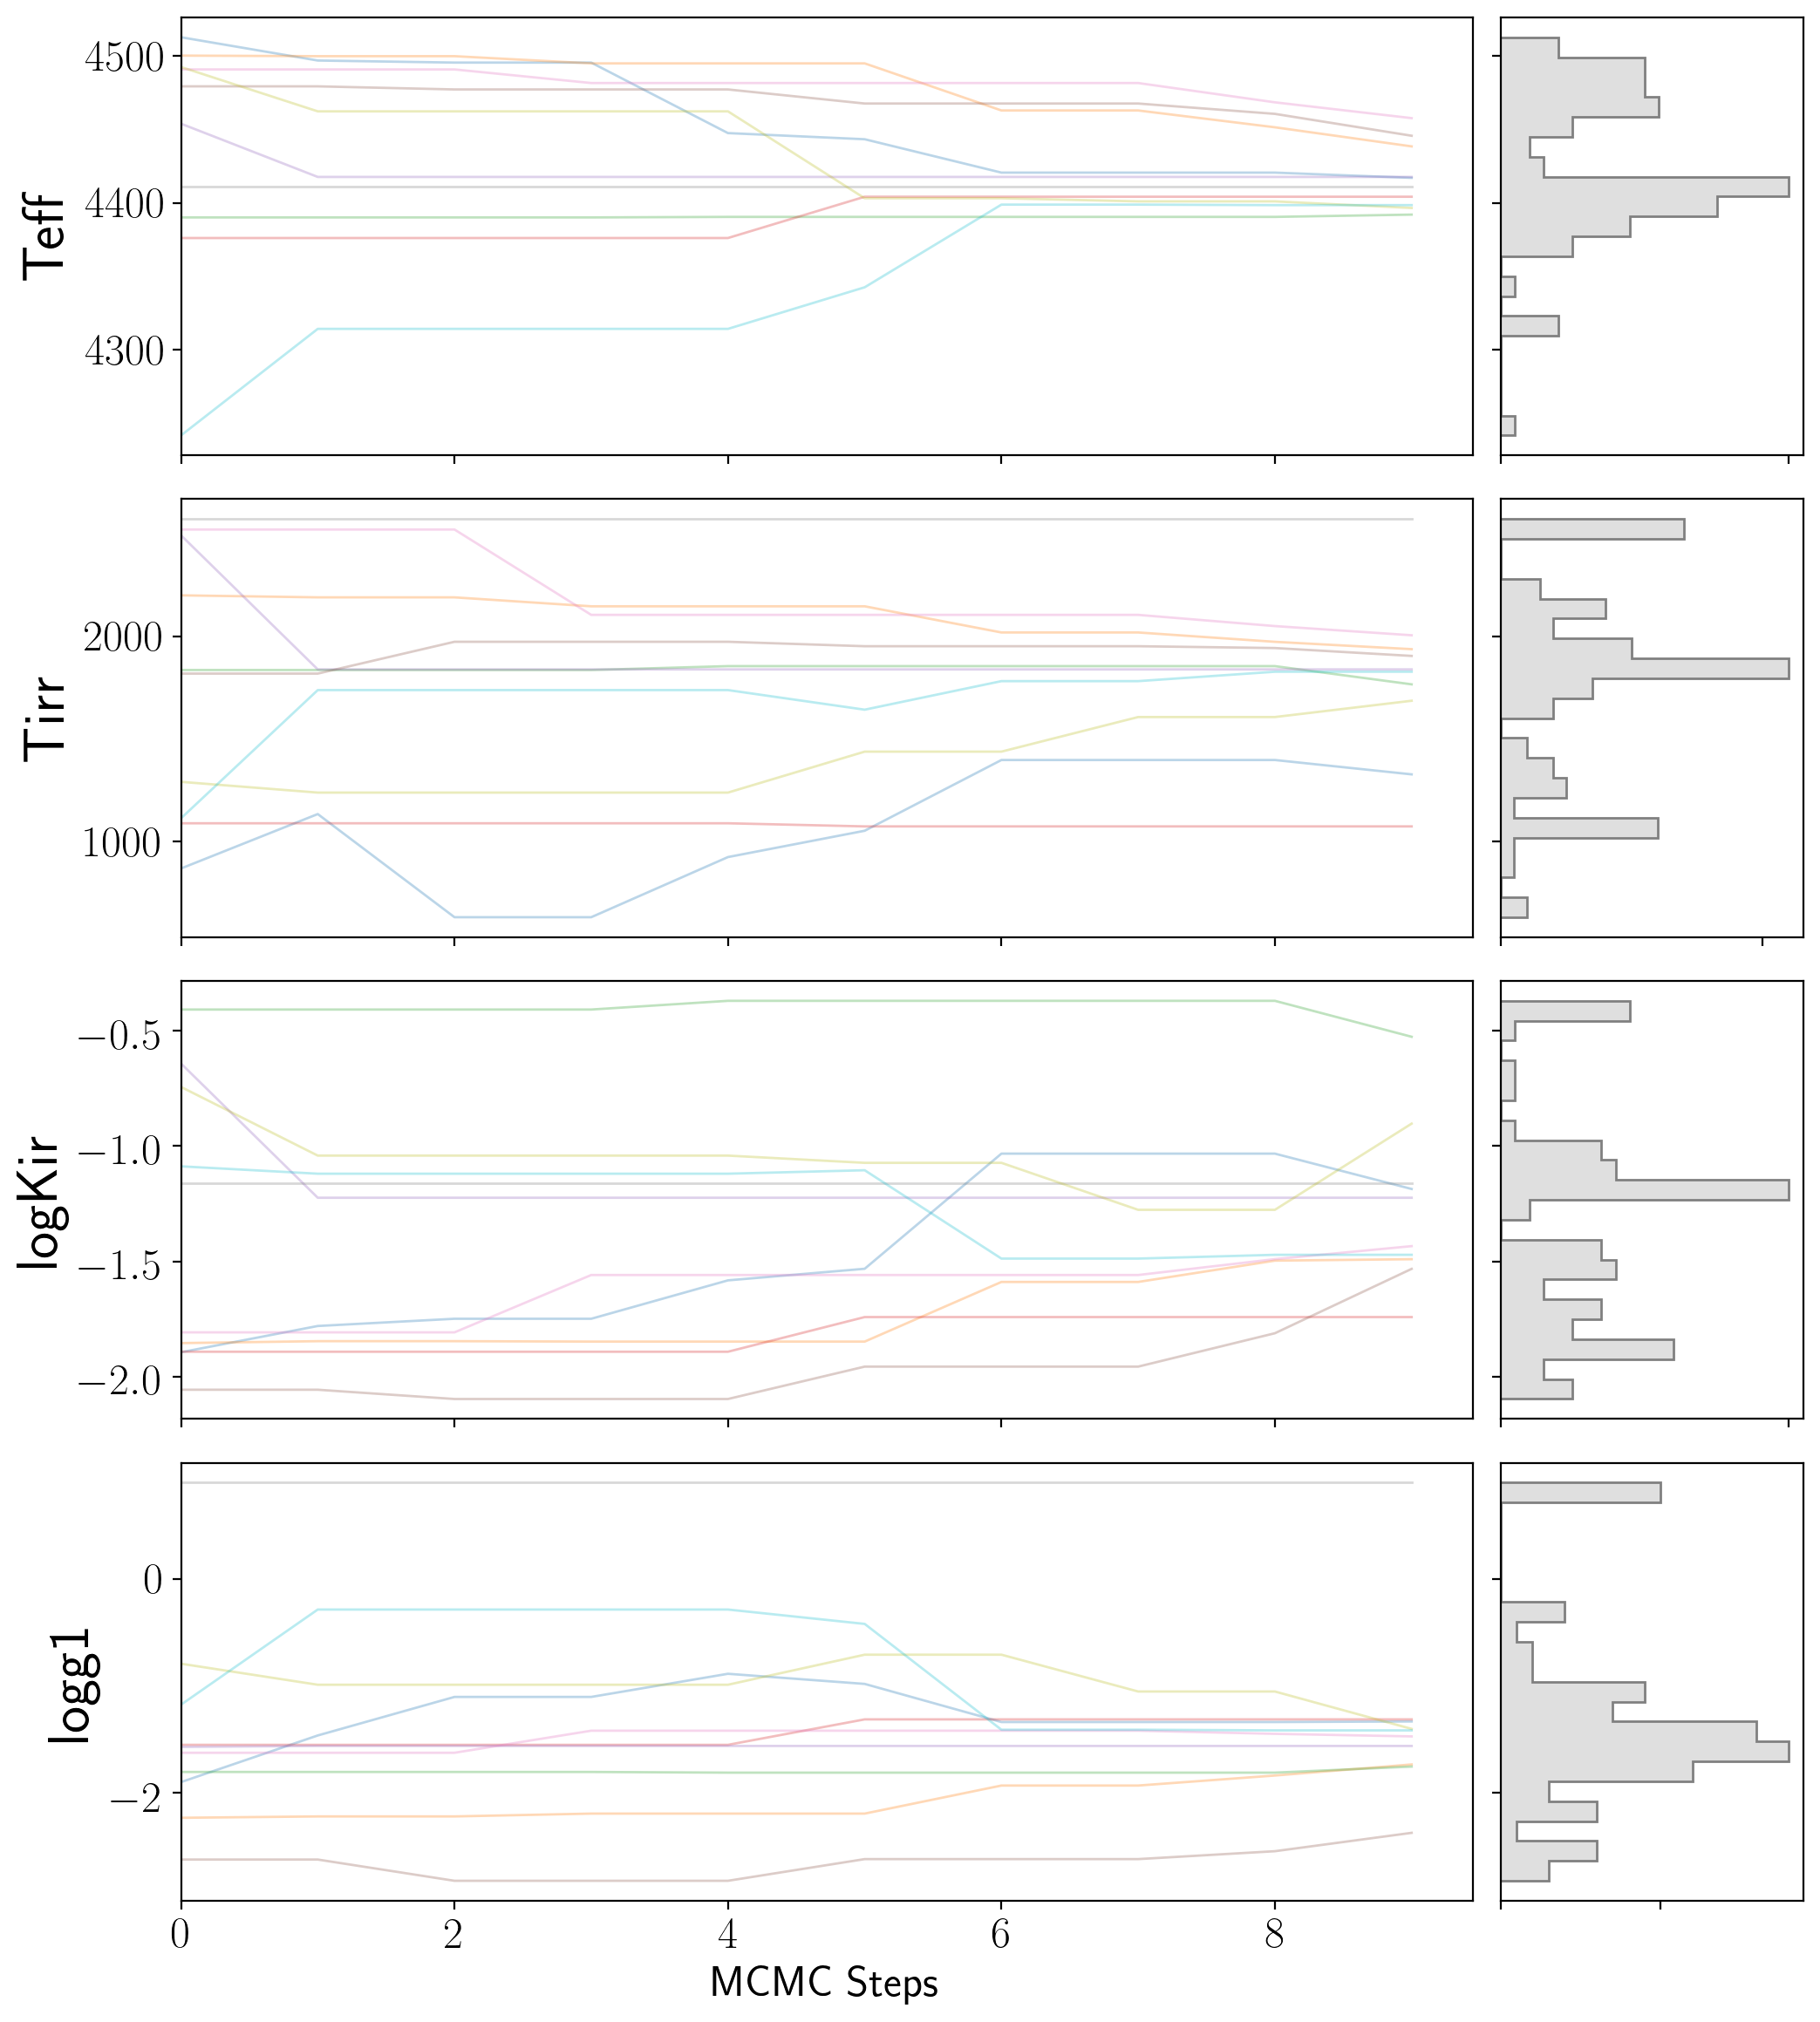

In [108]:
fig, ax = plot_mcmc_trace("example", saveplot=False, emcee_backend=sampler.backend, 
                          labels = theta_names)

In [42]:
flatchain = sampler.get_chain(flat=True, discard = 60)
m = np.sum(np.fabs(flatchain - np.median(flatchain, axis=0)) > 3.0*np.std(flatchain, axis=0), axis =1) == 0

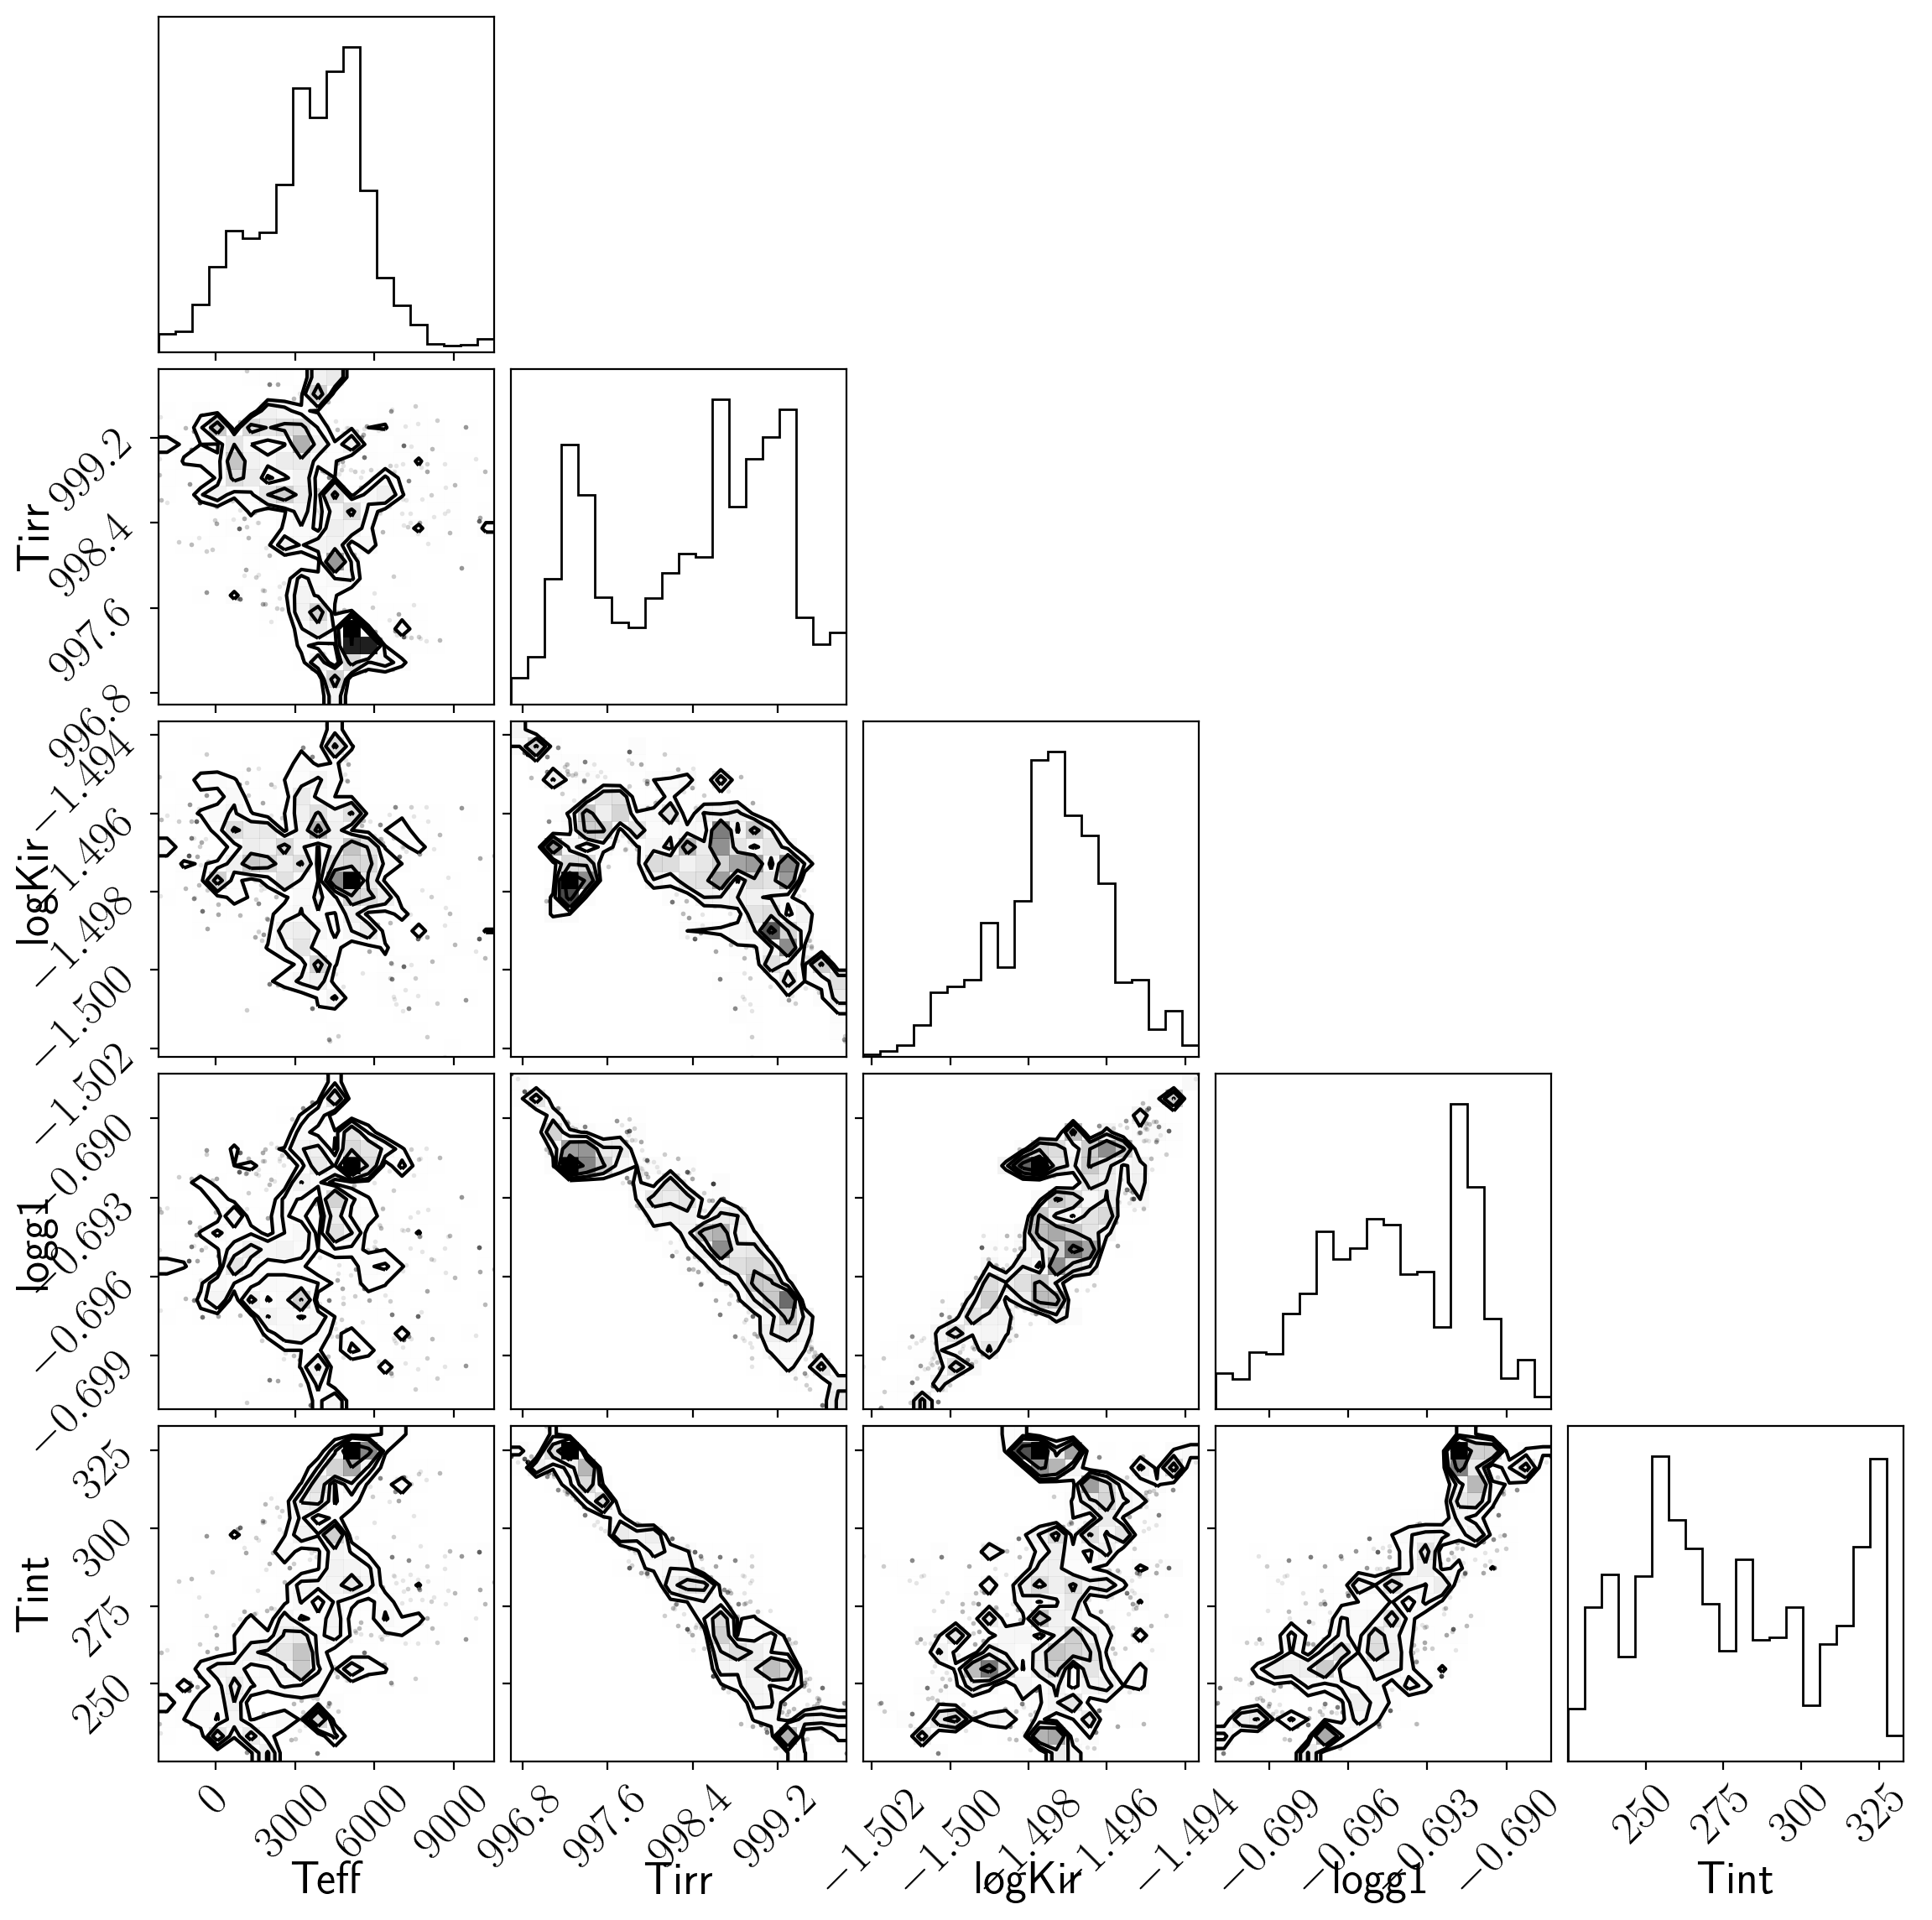

In [65]:
fig = corner.corner(flatchain[m], labels = theta_names)

In [43]:
import seaborn as sns
import pandas as pd

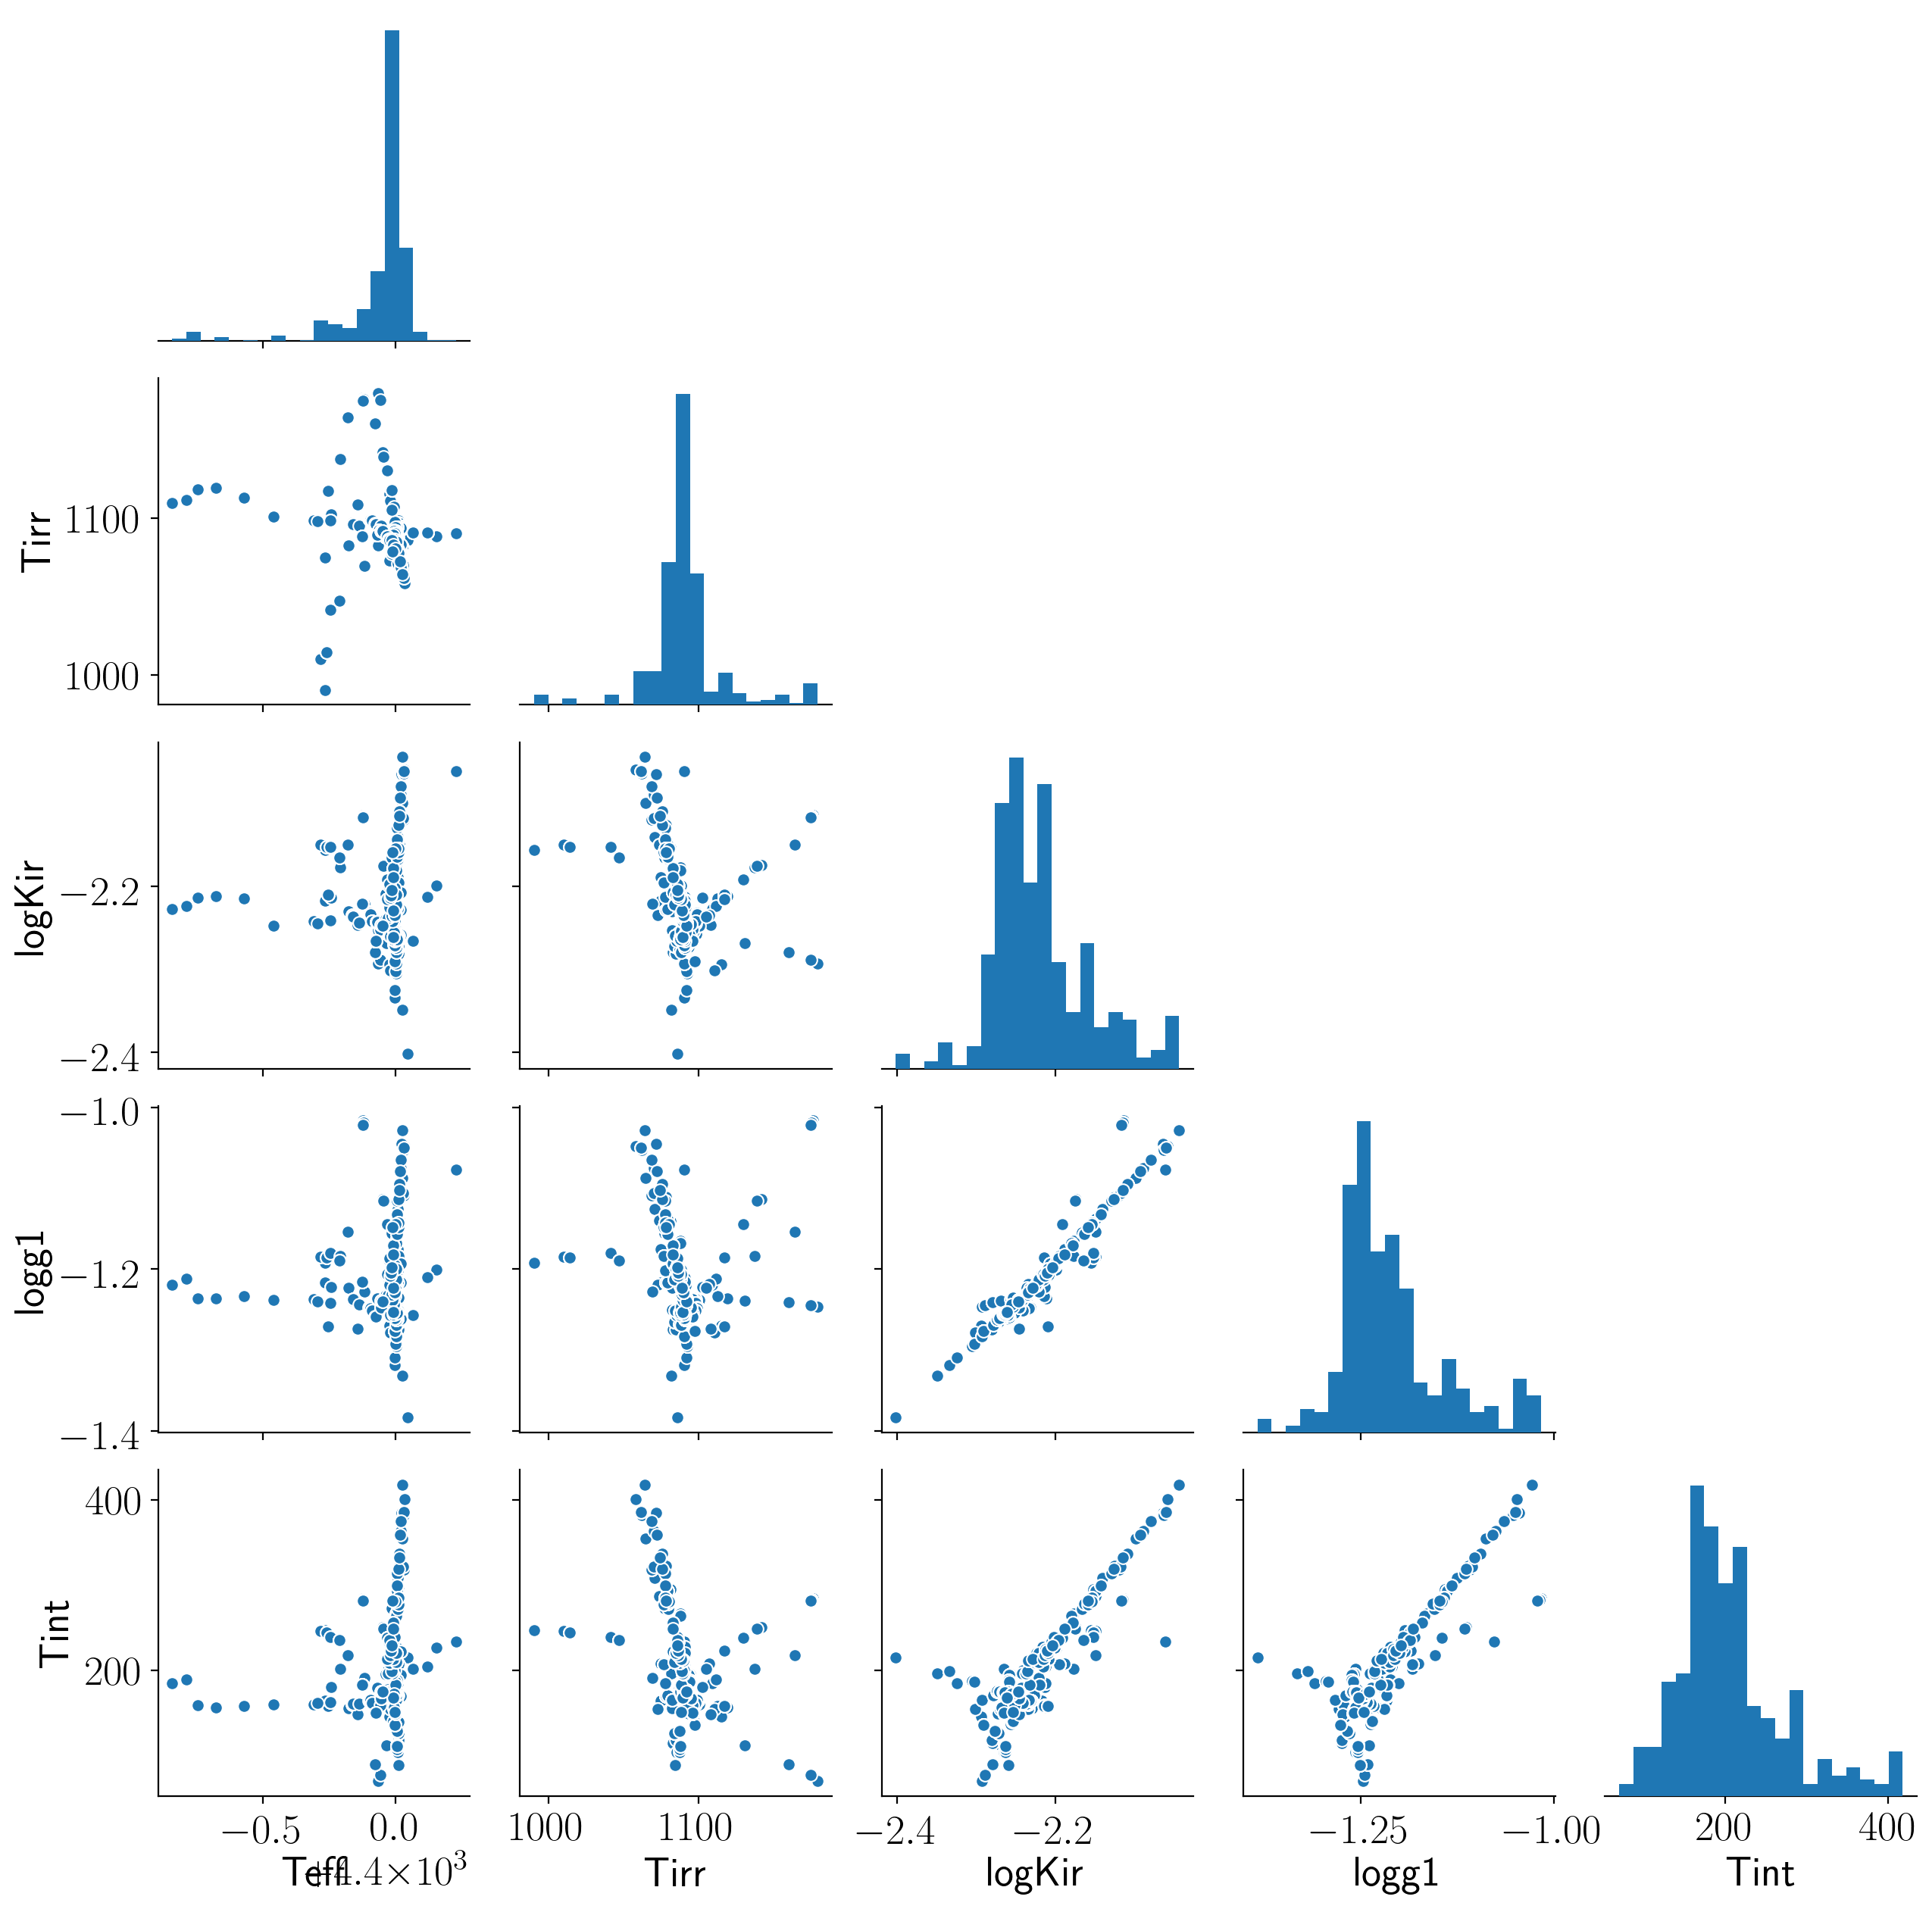

In [44]:
df = pd.DataFrame(flatchain[m], columns=theta_names)
_ = sns.pairplot(df, corner=True, diag_kws={"bins" : 20, "alpha" : 1.0})

## Analyze some samples

In [45]:
theta_run = np.median(flatchain[m], axis=0)

In [86]:
theta_run = flatchain[m][-2]

In [46]:
print(theta_run)
y_binned, y_star, y_planet = run_pie_model(theta_run)

[ 4.39999598e+03  1.08926370e+03 -2.23063340e+00 -1.23236285e+00
  1.95495934e+02]


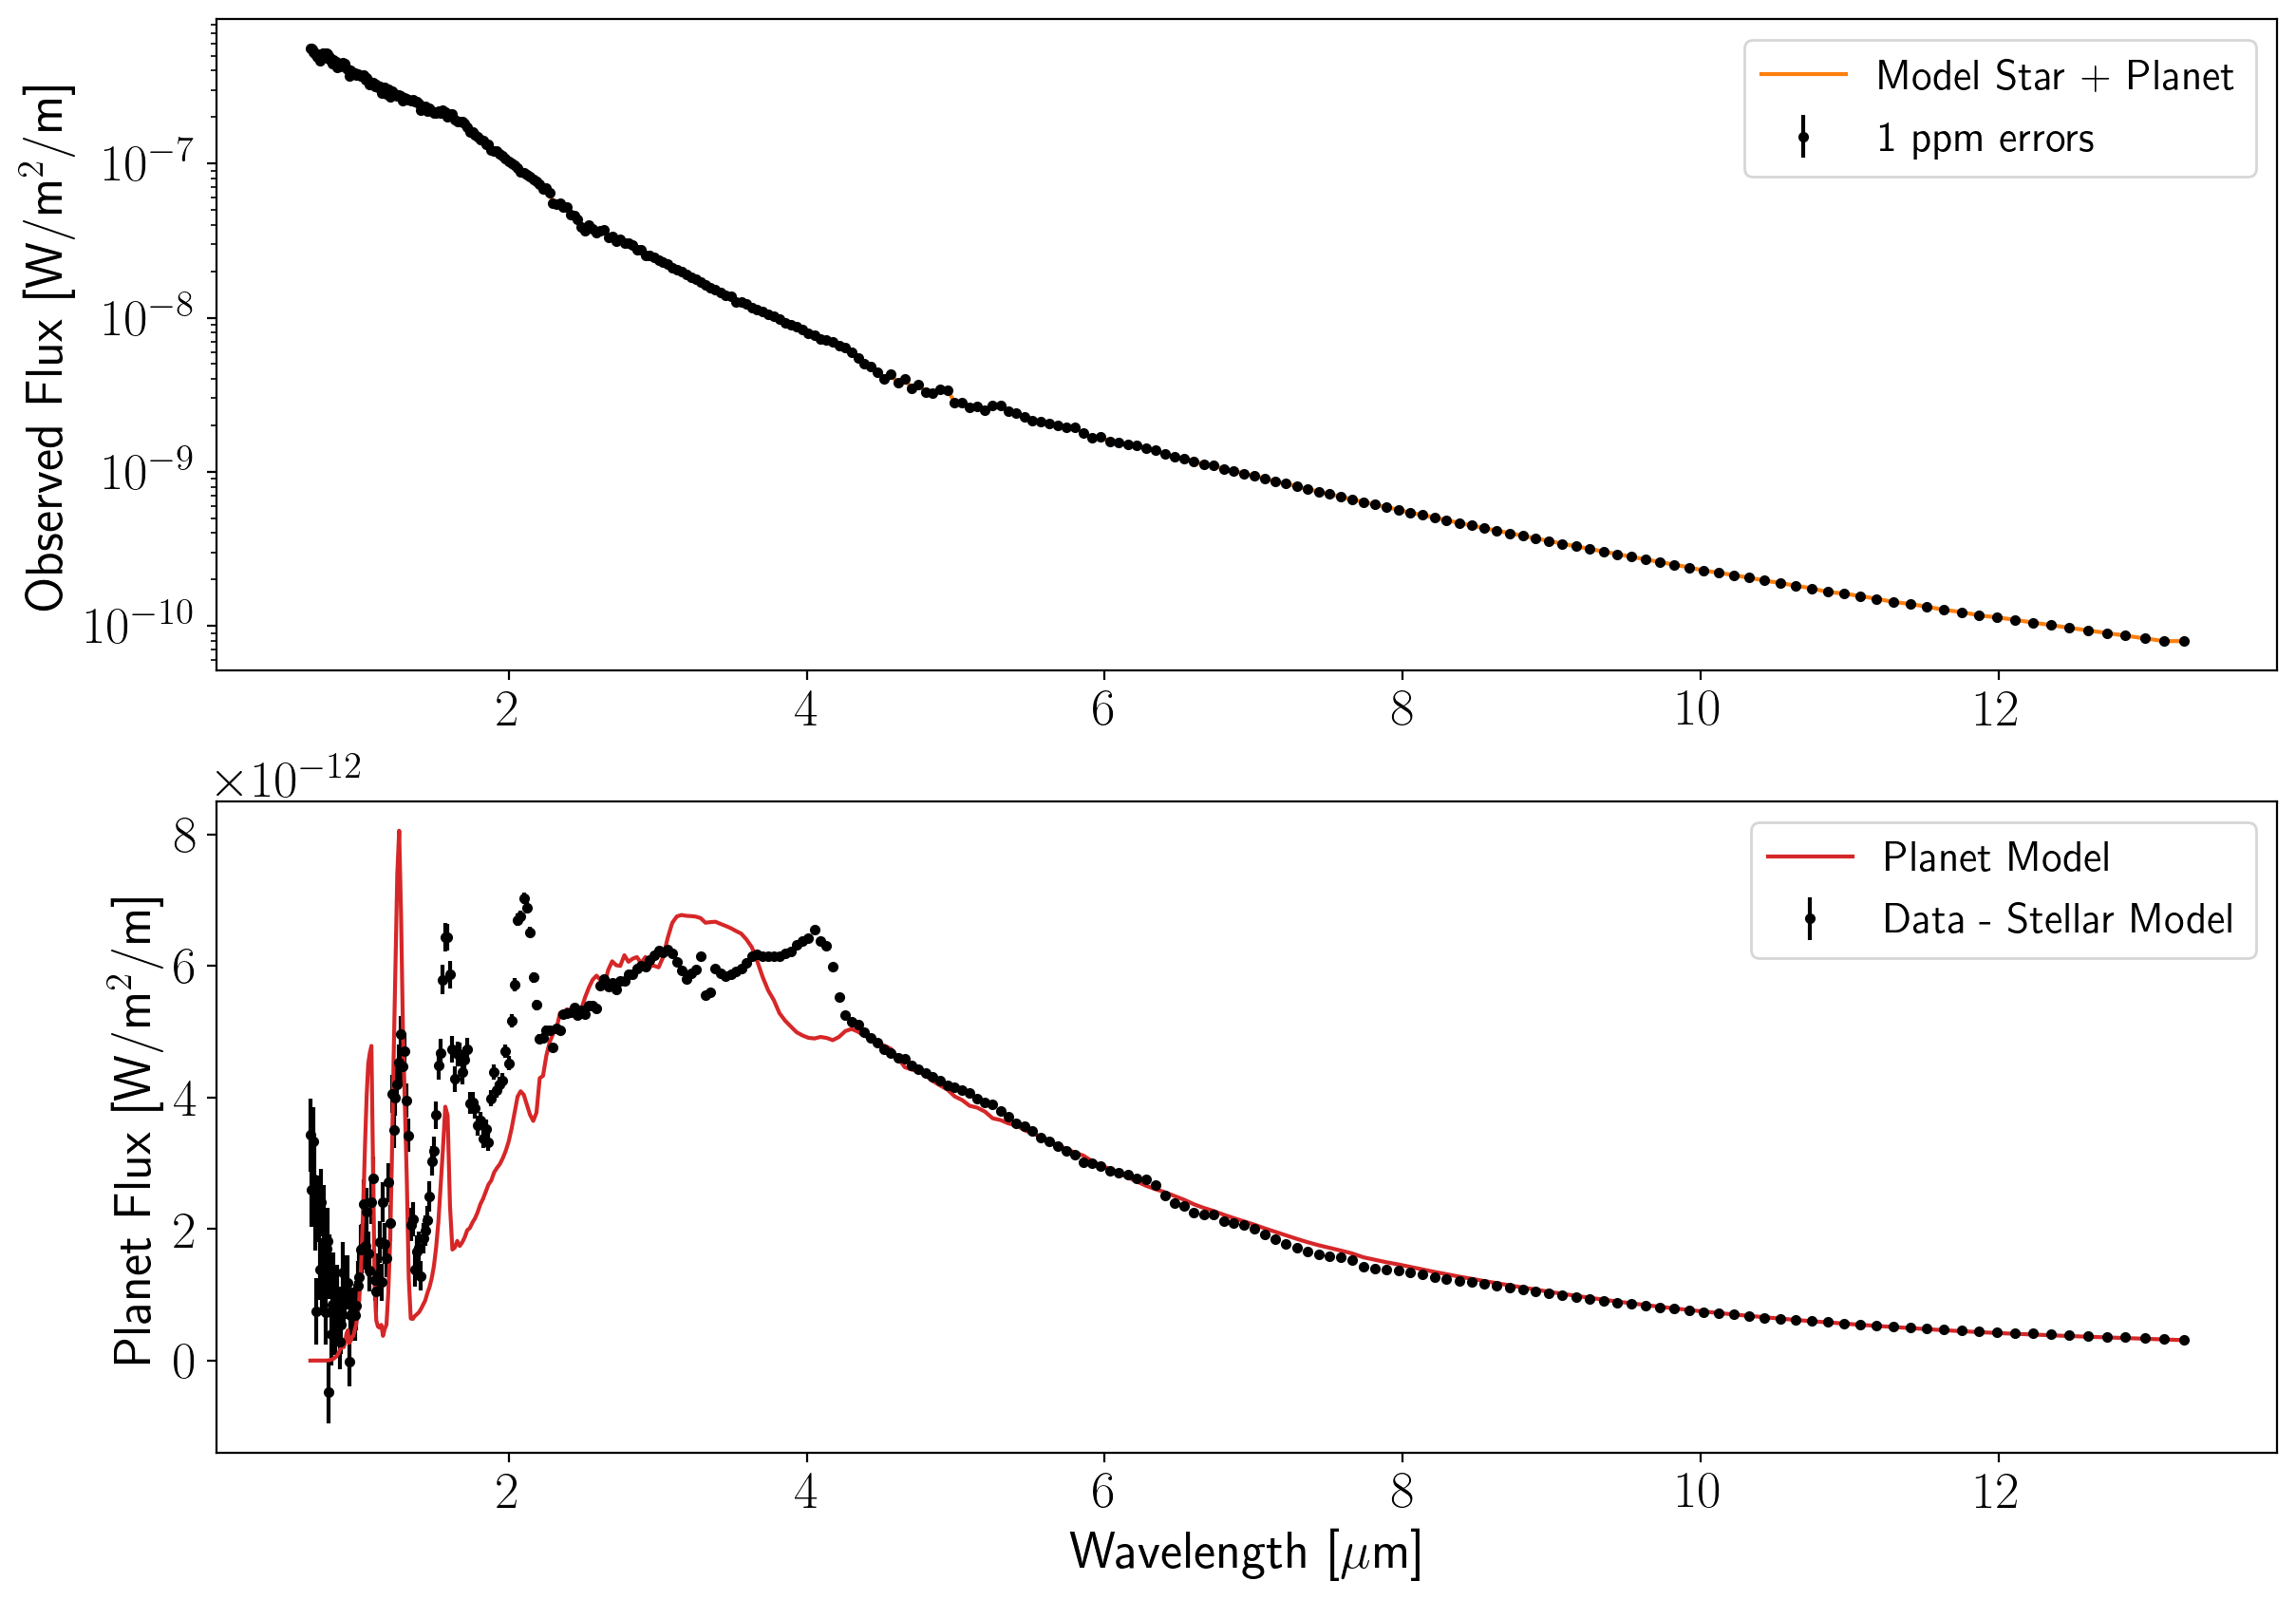

In [47]:
fig, axes = plt.subplots(2,1, figsize = (14, 10))

ax= axes[0]
ax2 = axes[1]


ax2.set_xlabel("Wavelength [$\mu$m]")
ax.set_ylabel("Observed Flux [W/m$^2$/m]")

#ax.plot(wl, Ftoa, label = "Planet Thermal + Relected", color = "C2")
#ax.plot(wl, Fstar, label = "Star Only", color = "C1")
#ax.plot(wl, Fstar + Fup_therm, label = "Star + Planet thermal", color = "k")
#ax.plot(wl, Fup_therm, label = "Planet Thermal", color = "C3")
#ax.plot(wl, Fup_ref, label = "Planet Reflected", color = "C0")
#ax.plot(wl, Fup_therm + Fup_ref)

ax.plot(wl, y_binned, label = "Model Star + Planet", color = "C1")
#ax.plot(wl, y_planet, label = "Planet thermal", color = "C3")
ax.errorbar(wl, y_meas, yerr=err, fmt = ".k", label = "%i ppm errors" %(escale / 1e-6))
#ax.plot(wl, y_planet, color = "C3", label = "Planet Model")

ax.set_yscale("log")
ax.legend(fontsize = 16)

ax2.set_ylabel("Planet Flux [W/m$^2$/m]")
ax2.plot(wl, y_planet, color = "C3", label = "Planet Model")
ax2.errorbar(wl, y_meas - y_star, yerr = err, fmt=".k", label = "Data - Stellar Model")
ax2.legend(fontsize = 16)
#fig.savefig("/Users/lustija1/Desktop/tmp.png", bbox_inches = "tight")

## Run minimization

In [74]:
from scipy.optimize import minimize

In [75]:
# Run minimization
output = minimize(neg_loglike, theta0,
                  method="Nelder-Mead", bounds=smarter.priors.get_theta_bounds(priors),
                  options = {"maxiter" : 2})

/Users/lustija1/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minimize.py:533: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


In [129]:
import schwimmbad

In [130]:
schwimmbad.SerialPool

schwimmbad.serial.SerialPool